In [101]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os
from tqdm import tqdm
import numpy as np
import fiona
import pandas as pd 
from shapely.strtree import STRtree

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shape - columns like name, population, elevation and the like.

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [102]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Severity, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

In [103]:
coord_ref_sys = "EPSG:25829" 
# Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation

### Filter out to our target area: Portugal

In [113]:
# GeoPandas looks in the same directory for data files by default (.dbf, .shx, etc.)
fire_data = gpd.read_file(FIRE_DATA_PATH)
fire_data = fire_data.to_crs(coord_ref_sys) # reproject to our fixed CRS
fire_data = fire_data[fire_data["COUNTRY"] == "PT"]
# fire_data = fire_data.iloc[:100]
fire_data.head()
fire_data["FIREDATE"].nunique()

6055


,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4..."
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,0,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4..."
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,0,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4..."
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,0,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45..."


In [114]:
fire_data.head()
# fire_data["FIREDATE"].nunique()

3597

In [115]:
world = gpd.read_file(COUNTRY_BOUNDARY_PATH)
portugal = world[world["NAME"] == "Portugal"]

# https://epsg.io/25829
# Reprojection of Portugal to our fixed CRS (specified above)
portugal_proj = portugal.to_crs(coord_ref_sys) # degrees -> met
mainland = portugal_proj.iloc[portugal_proj.geometry.area.argmax()]
mainland_polygon = mainland.geometry

# Extract bordering box around Portugal
minx, miny, maxx, maxy = mainland_polygon.bounds
print(minx, miny, maxx, maxy)

454235.1439060115 4077542.239783567 718319.3451133408 4681179.434351782


In [116]:
grid_size = 3000 # meters - discretization size of what one node is in our graph
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

In [117]:
# create grid
grid_squares = []
for x in x_coords:
    for y in y_coords:
        # this makes a full rectangle grid
        cell = box(x, y, x + grid_size, y + grid_size)
        # only add cells that are inside mainland portugal (leave out the sea)
        if mainland_polygon.contains(cell):
            grid_squares.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_squares}, crs=coord_ref_sys)
grid.head()
# each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

,geometry
0,"POLYGON ((460235.144 4284542.24, 460235.144 42..."
1,"POLYGON ((460235.144 4287542.24, 460235.144 42..."
2,"POLYGON ((460235.144 4290542.24, 460235.144 42..."
3,"POLYGON ((460235.144 4293542.24, 460235.144 42..."
4,"POLYGON ((460235.144 4296542.24, 460235.144 42..."


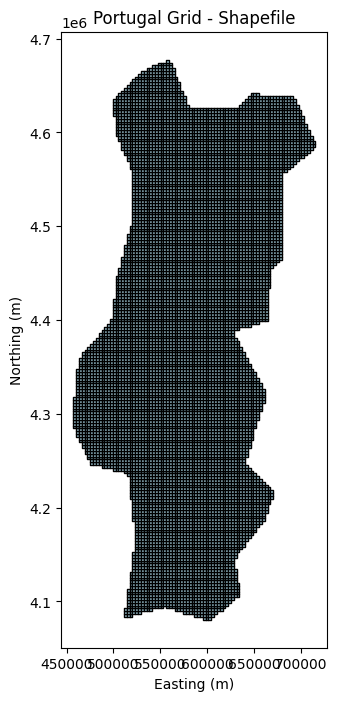

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
grid.plot(ax=ax, edgecolor='black', facecolor='lightblue')
ax.set_title("Portugal Grid - Shapefile")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

In [118]:
OUTPUT_DIRECTORY = 'output'
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)
grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.shp"))
grid.to_file(os.path.join(OUTPUT_DIRECTORY,"portugal_grid.gpkg"), layer="grid", driver="GPKG")

In [147]:
# add columns for coordinates of grid squares' centers
grid_gdf = grid.copy()
#rename geometry to geometry grid
# grid_gdf = grid_gdf.rename(columns={'geometry': 'geometry_grid'})
grid_gdf["centroid_grid"] = grid.geometry.centroid
grid_gdf["centroid_x_grid"] = grid.geometry.centroid.x
grid_gdf["centroid_y_grid"] = grid.geometry.centroid.y
grid_gdf.head()

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.24),458735.143906,4.286042e+06
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.24),458735.143906,4.289042e+06
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.24),458735.143906,4.292042e+06
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.24),458735.143906,4.295042e+06
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.24),458735.143906,4.298042e+06


In [100]:
# Path to GDB of Water
gdb_path = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

# List of layer indices we need
layer_indices = [0, 1, 6, 8, 9]

# Read and concatenate all water layers
water_gdfs = []
for idx in layer_indices:
    layer_name = fiona.listlayers(gdb_path)[idx]
    gdf_layer = gpd.read_file(gdb_path, layer=layer_name)
    water_gdfs.append(gdf_layer)

# Combine all layers into a single GeoDataFrame
water_gdf = gpd.GeoDataFrame(pd.concat(water_gdfs, ignore_index=True))
print("Combined water bodies:", water_gdf.shape)

grid_gdf = grid_gdf.set_geometry('centroid_grid')

# Ensure the CRS matches the water layer
grid_gdf = grid_gdf.to_crs(water_gdf.crs)

water_gdf = water_gdf[water_gdf.geometry.notnull()]
water_geoms = water_gdf.geometry.values
water_tree = STRtree(water_gdf.geometry.values)

def nearest_water(point):
    if point is None or point.is_empty:
        return None
    # nearest() now returns index
    nearest_idx = water_tree.nearest(point)
    nearest_geom = water_geoms[nearest_idx]  # get the actual geometry
    return point.distance(nearest_geom)

grid_gdf['dist_to_water'] = grid_gdf.geometry.apply(nearest_water)
grid_gdf.to_crs(coord_ref_sys, inplace=True)
grid_gdf.head()


Combined water bodies: (41321, 52)


,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.239),458735.143906,4.286042e+06,1170.927656
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.239),458735.143906,4.289042e+06,886.715418
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.239),458735.143906,4.292042e+06,493.847979
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.239),458735.143906,4.295042e+06,337.437963
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.239),458735.143906,4.298042e+06,670.219187


In [149]:
grid_gdf = grid_gdf.reset_index(drop=True)
grid_gdf["node_id"] = np.arange(len(grid_gdf))
grid_gdf.head()

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,node_id
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.24),458735.143906,4.286042e+06,0
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.24),458735.143906,4.289042e+06,1
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.24),458735.143906,4.292042e+06,2
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.24),458735.143906,4.295042e+06,3
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.24),458735.143906,4.298042e+06,4


#### Overlay with Fire Data

Assumption - if a centroid overlaps with a fire point - this is our fire node. We want to make this into a series, per date, for each fire.

In [120]:
# fires_with_centroids["centroid_x"] = fire_data["GEOMETRY"]
fire_data["centroid_x_fire"] = fire_data['geometry'].apply(lambda x: x.centroid.x)
fire_data["centroid_y_fire"] = fire_data['geometry'].apply(lambda y: y.centroid.y)
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4...",569537.929816,4.526903e+06
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4...",578340.742797,4.584768e+06
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4...",526512.771879,4.401550e+06
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4...",606905.317296,4.457301e+06
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45...",549250.037391,4.572389e+06


In [127]:
from datetime import datetime
import pandas as pd

fire_data["DAY"] = pd.to_datetime(fire_data["FIREDATE"], format='mixed').dt.date
# fire_data["FIREDATE"].nunique()
# fire_data["DAY"].nunique()
grouped_by_day = fire_data.groupby("DAY").size().reset_index(name='fire_count')
grouped_by_day.head()
grouped_by_day.shape


(1284, 2)

In [128]:
 def safe_stat(value, func="mean"):
    """Safely compute a statistic from a pandas Series, scalar, or missing value."""
    if value is None or isinstance(value, (float, int, np.generic, type(pd.NA))):
        return value if isinstance(value, (float, int)) else None
    
    try:
        if func == "mean":
            return value.mean()
        elif func == "sum":
            return value.sum()
        elif func == "mode":
            mode = value.mode()
            return mode.iloc[0] if not mode.empty else None
    except Exception:
        return None


Clustering in terms of weather data to reduce number of API calls

### Aggregate Grid Based on Day

# Important: This is currently set to break after one step

In [150]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np


fire_data = fire_data.to_crs(grid_gdf.crs)
graphs = []
for day in tqdm(grouped_by_day["DAY"]):
    fire_data_day = fire_data[fire_data["DAY"] == day].copy()
    fire_data_day['geometry'] = fire_data_day.geometry.centroid

    fire_centroids = fire_data_day.copy()
    fire_centroids['geometry'] = fire_data_day.geometry.centroid
    print(fire_centroids['geometry'])
    # Perform spatial join: fire centroid within grid polygons - Faster than iterating over each centroid - https://www.youtube.com/watch?v=y85IKthrV-s
    # We join POINT with POLYGON

    print("Fire shape: ", fire_centroids.shape)
    print("grid shape: ", grid_gdf.shape)
    grid_gdf = grid_gdf.set_geometry("geometry")
    fire_centroids = fire_centroids.set_geometry("geometry")
    joined = gpd.sjoin(grid_gdf, fire_centroids, how="left", predicate="covers")

    agg = (
        joined
        .assign(_hit = joined["index_right"].notna().astype(int))
        .groupby(level=0)  # group by grid cell index
        .agg(fire_count=("index_right", "count"),
             has_fire=("_hit", "max"))
    )

    # Merge back to geometry; fill missing (no matches) with zeros
    joined_one_row = grid_gdf.join(agg, how="left").fillna({"fire_count": 0, "has_fire": 0})
    joined_one_row["fire_count"] = joined_one_row["fire_count"].astype(int)
    joined_one_row["has_fire"]   = joined_one_row["has_fire"].astype(int)

    joined_one_row["node_id"] = grid_gdf["node_id"].values
    joined_one_row["DAY"] = pd.to_datetime(day).normalize()

    graphs.append(joined_one_row)
    # joined["geometry_centroid"] = joined.geometry.centroid
    # coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]
    #
    # # Note: this method does not handle an edge case where multiple fires occured at the same place,
    # joined["fire_intensity"] = 0
    #
    # for filename in os.listdir(WILDFIRE_SEVERITY_DIR):
    #     if filename.endswith(".tiff"):
    #         filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
    #         with rasterio.open(filepath) as src:
    #
    #             # Ensure CRS match
    #             if joined.crs != src.crs:
    #                 joined = joined.to_crs(src.crs)
    #                 joined["geometry_centroid"] = joined.geometry.centroid
    #                 coords = [(geom.x, geom.y) for geom in joined.geometry_centroid]
    #
    #             values = np.array([val[0] for val in src.sample(coords)])
    #             joined["fire_intensity"] = np.maximum(joined["fire_intensity"], values)
    #
    # print(joined.columns)
    # results = []
    # i = 0
    # for point, date in tqdm(zip(joined["geometry_centroid"], joined["DAY"]), total=len(joined)):
    #     if point is None or pd.isna(date):
    #         continue
    #
    #     location = Point(point.y, point.x)
    #
    #     # UTC timestamps for Meteostat
    #     start = pd.Timestamp(date)
    #     end = start + timedelta(days=1)
    #
    #     # Fetch hourly data
    #     df = Hourly(location, start, end).fetch()
    #     if df.empty:
    #         i+=1
    #
    #     if not df.empty:
    #         # Aggregate all hours in that day
    #         results.append({
    #             "DAY": date,
    #             "lat": point.y,
    #             "lon": point.x,
    #             "temp_mean": safe_stat(df["temp"], "mean"),
    #             "rhum_mean": safe_stat(df["rhum"], "mean"),
    #             "wdir_mean": safe_stat(df["wdir"], "mean"),
    #             "wspd_mean": safe_stat(df["wspd"], "mean"),
    #             "pres_mean": safe_stat(df["pres"], "mean"),
    #         })
    #
    # weather_df = pd.DataFrame(results)
    # joined = pd.concat([joined, weather_df], axis=1)
    #
    # graphs.append(joined_one_row)


  0%|          | 5/1284 [00:00<00:28, 44.39it/s]

757     POINT (559542.636 4622287.791)
1082    POINT (590296.674 4572179.771)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
791     POINT (581497.383 4593567.344)
1045    POINT (591501.552 4602339.031)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
1095    POINT (536045.509 4649753.285)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1224    POINT (535228.394 4647160.554)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1146    POINT (614760.041 4199521.215)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
152    POINT (632712.739 4572695.056)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
125    POINT (582564.966 4501361.779)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
674      POINT (549765.633 4554090.36)
1034    POINT (546697.579 4564588.327)
1229    POINT (556268.245 4519991.

  1%|▏         | 17/1284 [00:00<00:25, 49.67it/s]

769    POINT (534888.435 4644050.443)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1005    POINT (641672.93 4494946.955)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
67     POINT (528931.846 4602207.811)
457    POINT (558628.085 4325520.485)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
315     POINT (647887.244 4402437.596)
371     POINT (544595.705 4598594.878)
1078      POINT (624928.2 4401306.096)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
306     POINT (685199.775 4557882.565)
1018    POINT (640458.933 4524131.155)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
500    POINT (622727.715 4471720.288)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
444    POINT (627256.016 4474773.474)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
89      POINT (547261.635 4571610.73)


  2%|▏         | 29/1284 [00:00<00:23, 52.51it/s]

20      POINT (576357.879 4564195.562)
38       POINT (564291.45 4549108.029)
47      POINT (587622.623 4506828.151)
60      POINT (566556.754 4567891.238)
183     POINT (539953.519 4506187.766)
188     POINT (546975.671 4538999.607)
217      POINT (565511.99 4562506.058)
255     POINT (563944.713 4594402.466)
304     POINT (560362.174 4559834.855)
346     POINT (564147.003 4597432.225)
434     POINT (564787.527 4586505.043)
440     POINT (565290.761 4592478.179)
453     POINT (564584.615 4559323.491)
472      POINT (547247.34 4569585.954)
476      POINT (558377.26 4523919.626)
480     POINT (538750.712 4623508.147)
485     POINT (575634.142 4555974.188)
722     POINT (643477.733 4521964.241)
847     POINT (558238.581 4601889.303)
873      POINT (572939.33 4612426.429)
989       POINT (544128.191 4643825.1)
1129    POINT (676709.978 4638384.613)
1162    POINT (573363.197 4545935.326)
1250    POINT (585932.982 4554228.243)
1294    POINT (545082.872 4465897.372)
1299    POINT (549958.904

  3%|▎         | 41/1284 [00:00<00:23, 53.38it/s]

370     POINT (656146.647 4522639.657)
568     POINT (593772.461 4614662.785)
1088    POINT (659130.552 4522689.659)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
347     POINT (639071.49 4493256.689)
633    POINT (592333.392 4561416.735)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
6       POINT (606905.317 4457301.419)
616     POINT (585812.795 4542848.636)
1217    POINT (550386.806 4623063.527)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
398    POINT (569282.593 4379431.742)
618    POINT (590575.643 4544999.735)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
760     POINT (589675.49 4600805.334)
969    POINT (668184.106 4533297.303)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
1016    POINT (587114.54 4440547.869)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
198     POINT (579519.281 4616953.685)

  5%|▍         | 59/1284 [00:01<00:22, 55.41it/s]

663     POINT (589027.213 4623702.668)
1142    POINT (566174.387 4594362.641)
1195    POINT (543356.343 4560966.771)
1319    POINT (576982.918 4601102.553)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
5       POINT (526512.772 4401549.956)
150      POINT (542427.72 4430718.879)
184     POINT (607093.841 4587613.934)
251     POINT (575401.349 4604968.975)
329     POINT (578133.605 4541558.482)
352     POINT (610601.671 4613616.082)
417     POINT (594793.174 4620369.563)
496     POINT (593567.005 4544610.817)
578      POINT (542429.805 4428418.37)
999     POINT (563824.875 4606072.944)
1000    POINT (562283.531 4601846.941)
1135      POINT (566970.07 4591355.76)
Name: geometry, dtype: geometry
Fire shape:  (12, 22)
grid shape:  (10041, 5)
22      POINT (580461.253 4621271.705)
285     POINT (565180.922 4636937.209)
295     POINT (543845.144 4621841.669)
299     POINT (547441.595 4563158.115)
400     POINT (588738.042 4602739.758)
418     POINT (689987.527 

  5%|▌         | 65/1284 [00:01<00:21, 55.68it/s]

770    POINT (609879.947 4496247.17)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1215    POINT (640541.04 4492662.014)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1084    POINT (628301.302 4537872.283)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
691    POINT (605867.01 4628489.388)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
551    POINT (637961.053 4486178.993)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
24      POINT (614476.649 4592739.866)
222     POINT (588902.452 4539120.459)
1258     POINT (620995.685 4578881.94)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
606     POINT (639132.429 4452731.338)
737      POINT (669134.414 4467350.58)
854     POINT (598030.563 4531684.002)
1089    POINT (606864.358 4628632.681)
1242      POINT (551031.341 4619951.6)
Name: geometry, dtype: geometry
Fire 

  6%|▌         | 77/1284 [00:01<00:22, 53.79it/s]

620    POINT (574232.063 4652270.144)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
144     POINT (558293.994 4625166.745)
268     POINT (575689.652 4591263.124)
436     POINT (564981.129 4658078.096)
1223    POINT (578828.395 4596989.729)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
539      POINT (589957.319 4542568.54)
903      POINT (574375.676 4654144.67)
1042    POINT (543128.319 4645288.051)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
1038    POINT (580059.808 4535050.652)
1108    POINT (557738.881 4623482.754)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
143    POINT (576092.791 4539480.115)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
589      POINT (586065.38 4535612.35)
590    POINT (575197.498 4537116.851)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
151    POINT (590878.31 4623666.298

  7%|▋         | 89/1284 [00:01<00:22, 53.13it/s]

2266    POINT (599372.115 4523837.868)
2426    POINT (603695.836 4579108.068)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
1594    POINT (598206.256 4574937.777)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1946    POINT (604662.425 4633196.411)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2019    POINT (596678.76 4633758.426)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1968    POINT (564865.663 4457631.291)
2274    POINT (600792.427 4582390.527)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
3099    POINT (608659.44 4630497.866)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2865    POINT (604048.631 4532327.069)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1937    POINT (595611.77 4616851.567)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 

  8%|▊         | 101/1284 [00:01<00:22, 52.39it/s]

1450    POINT (572203.052 4595192.664)
1742    POINT (685425.457 4641263.275)
3277    POINT (605253.807 4638189.775)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
1642    POINT (586246.827 4623292.682)
1930    POINT (581399.408 4538347.492)
3732    POINT (613862.738 4631556.388)
3880    POINT (593663.153 4632363.734)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
2162    POINT (644180.313 4633187.322)
3232    POINT (548207.358 4639114.748)
4066     POINT (606928.545 4535892.11)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
2110    POINT (650517.275 4499676.155)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2026    POINT (575299.929 4654673.127)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1942    POINT (593430.192 4577236.918)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2217    POINT (562158.711 46310

  9%|▉         | 113/1284 [00:02<00:21, 53.50it/s]

2228    POINT (571851.215 4593807.45)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1708     POINT (648286.249 4636133.61)
1786    POINT (579883.497 4607688.334)
1896    POINT (651079.437 4644835.943)
2232    POINT (551775.078 4617362.695)
2279    POINT (560806.137 4628712.063)
3884    POINT (551957.687 4633662.176)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
2164    POINT (585296.34 4580076.816)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1610    POINT (644189.684 4632317.053)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2093    POINT (652285.584 4626504.499)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1487    POINT (623365.459 4578647.563)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1507    POINT (651381.125 4636579.499)
2353    POINT (649291.515 4626351.033)
Name: geometry, dtype: geometry
F

 10%|▉         | 125/1284 [00:02<00:24, 47.99it/s]

2988    POINT (622480.764 4579632.641)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1361    POINT (565053.575 4419692.845)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1627    POINT (607357.667 4429437.902)
2335    POINT (580243.659 4432993.851)
2895    POINT (648950.132 4516942.898)
3205    POINT (655775.783 4624252.497)
4434    POINT (660824.037 4539829.786)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
3207    POINT (731719.677 4603545.547)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1513    POINT (562395.324 4395978.085)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1643    POINT (655538.03 4561555.479)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2158    POINT (531531.097 4479135.705)
3954    POINT (673710.389 4601068.485)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (1004

 11%|█         | 135/1284 [00:02<00:26, 43.56it/s]

2192    POINT (582851.296 4388918.189)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1600    POINT (618836.374 4449388.12)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2857    POINT (537748.583 4206506.101)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1357    POINT (660001.122 4606092.241)
2854    POINT (688979.215 4560066.974)
3285    POINT (630924.913 4575550.617)
3327     POINT (662747.299 4590014.38)
3536    POINT (630886.734 4590472.455)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
1475    POINT (665104.569 4491850.346)
1591    POINT (614797.913 4492035.514)
1774    POINT (651163.924 4550526.543)
2307    POINT (588675.248 4417560.221)
3759    POINT (608125.006 4493126.552)
4009    POINT (665727.836 4605871.692)
4078     POINT (607259.01 4490530.547)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
1548    POINT (667319.241 45592

 11%|█         | 141/1284 [00:02<00:24, 46.03it/s]

3485    POINT (641829.828 4568300.099)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1929    POINT (558671.411 4454009.844)
3041    POINT (556539.652 4457565.496)
3234    POINT (611063.177 4489335.278)
4038    POINT (589088.359 4494829.594)
4180    POINT (579852.409 4400160.174)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
1394    POINT (638531.336 4503201.552)
1668    POINT (670651.974 4486192.127)
1846     POINT (678774.32 4515622.499)
4056    POINT (655478.858 4484913.238)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
3642    POINT (663209.392 4567871.168)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1722    POINT (621146.431 4607482.477)
3851    POINT (639018.635 4231890.834)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
2277    POINT (562326.113 4541614.669)
4211     POINT (581097.57 4493365.626)
4290    POINT (566818.816 4569

 12%|█▏        | 151/1284 [00:02<00:24, 46.99it/s]

1399    POINT (560242.637 4381295.244)
1420    POINT (543244.486 4460714.235)
1951    POINT (607116.155 4619567.125)
2097    POINT (661335.746 4545280.067)
2667     POINT (584734.532 4543272.56)
4396    POINT (563891.042 4564946.237)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
1482      POINT (546363.82 4214538.23)
1485    POINT (557939.394 4403915.565)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
1793    POINT (551289.025 4573961.071)
1965      POINT (557009.94 4448074.38)
4042    POINT (539277.872 4569903.174)
4209    POINT (540554.609 4570640.778)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
1346    POINT (616664.388 4577017.038)
1488     POINT (537520.769 4457469.89)
1685    POINT (567583.818 4394242.953)
1703    POINT (635402.781 4629470.983)
2252    POINT (626922.314 4437466.981)
2502    POINT (548297.734 4644739.309)
3439    POINT (539536.532 4471125.969)
3727    POINT (710259.113 45

 13%|█▎        | 161/1284 [00:03<00:25, 43.35it/s]

1919     POINT (616446.68 4486245.376)
2953     POINT (622930.04 4458671.315)
3185    POINT (595694.143 4593879.412)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
1500    POINT (587032.171 4542964.459)
1637    POINT (575375.674 4542827.211)
1906    POINT (584400.818 4589337.561)
1935     POINT (539967.002 4589915.99)
1947    POINT (552286.057 4554844.651)
2369    POINT (569196.666 4570110.088)
2830     POINT (587013.797 4554057.73)
2876    POINT (586578.049 4598583.643)
2902    POINT (571557.083 4549291.812)
3117    POINT (571325.245 4542196.381)
3918    POINT (548724.337 4554495.677)
3972    POINT (577179.842 4599426.697)
3986    POINT (593422.381 4544955.335)
Name: geometry, dtype: geometry
Fire shape:  (13, 22)
grid shape:  (10041, 5)
1446    POINT (567090.186 4616633.968)
2344     POINT (590862.91 4554010.241)
2765     POINT (591624.09 4596797.066)
2795    POINT (657359.792 4530064.095)
3045    POINT (565040.801 4520398.516)
3067    POINT (658379.196 

 13%|█▎        | 173/1284 [00:03<00:22, 48.31it/s]

3688    POINT (664180.535 4574070.12)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2179    POINT (619810.73 4445888.581)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1406    POINT (581241.303 4407212.221)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1493     POINT (479347.91 4352407.718)
2012    POINT (628758.079 4535948.648)
3354    POINT (604905.253 4402766.304)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
4221    POINT (702394.842 4621685.375)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
1407    POINT (625824.183 4537417.381)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2903    POINT (-250575.037 3647300.091)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2923    POINT (606649.069 4638843.128)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041

 14%|█▍        | 183/1284 [00:03<00:24, 45.16it/s]

3602    POINT (598025.241 4575838.841)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2420    POINT (579623.403 4538362.226)
3081    POINT (649306.308 4617458.498)
3804    POINT (-256662.656 3647053.73)
3839    POINT (594692.426 4615783.592)
4100    POINT (560730.772 4655698.456)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
1932    POINT (584343.425 4603950.267)
2190    POINT (603931.417 4534528.062)
3735    POINT (584786.887 4533134.579)
3864    POINT (596082.432 4535866.721)
4127     POINT (563574.63 4651753.808)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
1662    POINT (579808.347 4600159.912)
3181    POINT (542853.341 4406624.685)
3910    POINT (660030.369 4553779.223)
4438    POINT (596841.436 4614385.059)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
1998     POINT (557460.26 4476004.209)
2405    POINT (602644.129 4585377.353)
2934    POINT (573077.551 458

 15%|█▌        | 193/1284 [00:03<00:23, 46.58it/s]

1397    POINT (622112.961 4577769.311)
1737    POINT (583709.392 4628153.509)
2129    POINT (575031.509 4501194.794)
3934    POINT (621805.741 4546317.921)
4143     POINT (650005.34 4619819.754)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
1852    POINT (577526.668 4623413.961)
1874    POINT (547900.075 4653522.783)
2216    POINT (574399.472 4468616.011)
2289    POINT (660349.598 4497616.614)
2305    POINT (577806.597 4610838.816)
2568    POINT (592538.544 4620985.635)
2625    POINT (587800.136 4635342.407)
2959    POINT (590212.036 4542295.713)
3056    POINT (573765.269 4612009.178)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
1363    POINT (668821.037 4517184.544)
1378    POINT (504675.932 4409871.076)
1432    POINT (586399.067 4429134.551)
1471     POINT (566803.29 4503842.364)
1519    POINT (551101.572 4643637.538)
1529    POINT (601471.326 4620432.328)
1536    POINT (616237.833 4478657.364)
1682     POINT (631675.32 4

 16%|█▌        | 203/1284 [00:04<00:22, 47.42it/s]

3364    POINT (595668.991 4554189.65)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
3309    POINT (580144.331 4532307.233)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
2882    POINT (555890.728 4625342.95)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
3676    POINT (535371.029 4649056.484)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4033    POINT (549308.968 4648315.563)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5299    POINT (642928.029 4616921.127)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4546    POINT (582223.64 4610980.33)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5003    POINT (594620.718 4600597.24)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4970    POINT (686564.511 4618045.679)
Name: geometry, dtype: geometry
Fire s

 17%|█▋        | 213/1284 [00:04<00:25, 42.74it/s]

5475    POINT (606830.579 4589422.259)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4602    POINT (545033.558 4646406.748)
4790    POINT (536448.402 4631227.117)
5274    POINT (579970.381 4533327.457)
5629    POINT (655660.334 4622937.244)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
5101     POINT (635211.78 4411081.418)
5119    POINT (678118.498 4469899.414)
5162      POINT (578615.58 4598852.01)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
4983    POINT (603950.384 4636970.815)
5002    POINT (598028.416 4626699.631)
5029    POINT (600984.815 4636793.912)
5150    POINT (557798.789 4622772.723)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
4841    POINT (672558.837 4489813.459)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4964    POINT (605904.994 4591596.668)
5040    POINT (604833.204 4591098.029)
5111    POINT (564547.274 4624

 17%|█▋        | 224/1284 [00:04<00:24, 43.35it/s]

4731    POINT (579591.661 4603139.497)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5069    POINT (555046.999 4612618.365)
5455    POINT (562091.432 4627723.923)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5242    POINT (594420.478 4588459.122)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5071    POINT (535572.576 4650171.676)
5480    POINT (578594.027 4588349.413)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5168    POINT (603734.261 4636036.304)
5538    POINT (574812.645 4577745.407)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5453    POINT (612674.135 4613270.071)
5595    POINT (599208.856 4627004.941)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
4549    POINT (544961.352 4128096.757)
5064    POINT (664467.483 4590093.048)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (100

 18%|█▊        | 229/1284 [00:04<00:24, 43.22it/s]

5366    POINT (667255.529 4617964.725)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5006    POINT (585294.67 4409551.551)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4937    POINT (560609.058 4594649.162)
5157     POINT (684094.39 4558205.763)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5345    POINT (666681.894 4572696.653)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4803    POINT (564649.606 4635556.569)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4808    POINT (646595.786 4473606.725)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5439    POINT (573124.172 4596833.195)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4706    POINT (675178.504 4577739.468)
5486    POINT (609401.819 4462157.002)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041

 19%|█▊        | 239/1284 [00:05<00:26, 40.15it/s]

4599    POINT (564247.894 4604646.853)
4814     POINT (586936.13 4138842.824)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5122    POINT (620063.904 4581982.732)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5022    POINT (588496.471 4405821.905)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4705    POINT (567791.683 4596980.632)
5551    POINT (550981.057 4617598.133)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
4828    POINT (566346.296 4604504.395)
4992    POINT (553073.244 4625929.638)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5432    POINT (545677.433 4620868.014)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5131    POINT (593659.293 4567210.086)
5284    POINT (552274.316 4620441.597)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
4567    POINT (578083.275 455284

 19%|█▉        | 250/1284 [00:05<00:22, 45.27it/s]

4523    POINT (623333.721 4502657.553)
4550    POINT (544410.688 4656434.905)
4717    POINT (568840.476 4545325.783)
4725    POINT (536546.717 4632423.973)
5488    POINT (547951.453 4514278.221)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
5335    POINT (581417.47 4593140.766)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4741    POINT (599902.052 4503052.356)
5200    POINT (653879.733 4649496.914)
5626    POINT (459771.338 4288857.603)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
4759    POINT (580308.987 4601096.678)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4605    POINT (553384.432 4631569.353)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4449    POINT (567734.86 4656094.805)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
4972    POINT (625799.144 4551098.817)
Name: geometry, dtype: geometry
F

 20%|██        | 261/1284 [00:05<00:21, 47.54it/s]

7213     POINT (574085.102 4652600.91)
7281    POINT (661764.944 4643354.012)
7744    POINT (608628.773 4601349.736)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
7116    POINT (594665.271 4631881.174)
8175    POINT (604768.442 4635828.769)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
6070    POINT (590658.773 4623715.622)
6185    POINT (562757.843 4650625.873)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
7695    POINT (589031.979 4633796.706)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6892     POINT (630449.371 4482488.12)
7033    POINT (576500.494 4540348.418)
7357    POINT (562848.453 4652725.672)
7485     POINT (572858.265 4654678.64)
8448    POINT (588576.353 4541878.862)
8490    POINT (589682.017 4626418.927)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
9484    POINT (584916.626 4605965.388)
Name: geometry, dtype: geometr

 21%|██        | 272/1284 [00:05<00:21, 48.19it/s]

6086    POINT (603712.275 4580526.717)
9176    POINT (629637.523 4481161.381)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
6838    POINT (590474.018 4637130.013)
7223    POINT (574398.715 4651700.823)
8028    POINT (592044.959 4636852.167)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
7445    POINT (598519.54 4574251.509)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6143    POINT (584088.775 4532040.558)
7309    POINT (603212.637 4633137.049)
8459    POINT (563682.048 4616729.333)
9047    POINT (602429.213 4634016.117)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
6889    POINT (558905.635 4625393.456)
7133    POINT (573847.597 4656303.807)
8109    POINT (556610.056 4656976.046)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
6116    POINT (605174.049 4590063.205)
6261    POINT (597902.607 4577115.976)
7271    POINT (646987.023 45063

 22%|██▏       | 284/1284 [00:05<00:20, 47.64it/s]

8167    POINT (545280.708 4619807.512)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5888    POINT (628981.275 4484259.834)
9478    POINT (668934.825 4645972.263)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
7530    POINT (528751.222 4603645.026)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5807    POINT (666613.286 4636903.708)
5846    POINT (602667.466 4402928.529)
9382    POINT (553556.952 4620598.699)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
6090     POINT (561952.841 4643012.21)
7813     POINT (513818.79 4620442.231)
8287    POINT (641768.723 4535794.003)
8561    POINT (543981.135 4499150.706)
8994     POINT (563759.14 4654140.483)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
5708    POINT (546929.432 4514759.567)
6305    POINT (559565.797 4556405.937)
6771    POINT (597679.695 4574292.908)
7375    POINT (591166.194 4615

 23%|██▎       | 294/1284 [00:06<00:22, 43.21it/s]

5777    POINT (562526.229 4182206.5)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8997    POINT (602888.316 4455525.685)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6394    POINT (-258725.171 3647854.412)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8707    POINT (630061.582 4224743.771)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5941    POINT (-271003.315 3657231.846)
8478     POINT (625148.139 4195309.157)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5804    POINT (651303.615 4561199.422)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5665    POINT (645614.773 4280995.397)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8140    POINT (561414.311 4160608.013)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8710    POINT (598887.423 417691

 23%|██▎       | 299/1284 [00:06<00:23, 41.23it/s]

6266    POINT (539760.391 4650236.408)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7314    POINT (631710.432 4449146.953)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8078    POINT (540229.714 4567637.261)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
9197    POINT (680924.926 4502296.384)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7888    POINT (653170.013 4547250.568)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6973    POINT (621169.32 4551026.776)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8624    POINT (515926.443 4128604.561)
8654    POINT (581203.718 4395007.629)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
7407    POINT (585667.396 4408725.221)
8602    POINT (588301.573 4405936.067)
9350    POINT (572802.972 4403601.397)
Name: geometry, dtype: geometry
F

 24%|██▍       | 308/1284 [00:06<00:26, 36.23it/s]

5862    POINT (635579.734 4531547.965)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7747    POINT (620377.278 4500869.893)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
9046    POINT (627170.317 4581985.019)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6255    POINT (623096.63 4430044.17)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6236    POINT (635112.841 4452040.191)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8017    POINT (584442.767 4123487.649)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7412    POINT (633275.588 4461198.717)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)


 24%|██▍       | 312/1284 [00:06<00:29, 33.51it/s]

6367    POINT (615803.824 4368794.266)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7950    POINT (558629.783 4375283.939)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
5935    POINT (654272.153 4584466.674)
8019    POINT (649830.134 4473942.605)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
5892    POINT (669791.451 4551028.049)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6522    POINT (664005.421 4572576.259)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)


 25%|██▍       | 320/1284 [00:07<00:32, 30.02it/s]

6744    POINT (621916.589 4583560.533)
7930    POINT (628162.449 4461205.436)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
9479    POINT (644389.368 4552915.399)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
9357    POINT (591298.277 4560141.511)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6182    POINT (659259.64 4474104.308)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
7904    POINT (702347.123 4604077.114)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6982     POINT (586369.401 4546402.98)
8799    POINT (684493.047 4591156.619)
9372    POINT (533478.809 4646430.516)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)


 25%|██▌       | 324/1284 [00:07<00:32, 29.15it/s]

6864    POINT (481263.965 4290316.188)
7749    POINT (546336.347 4393650.122)
8253    POINT (663553.361 4573102.314)
8394    POINT (608372.564 4556335.124)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
5891    POINT (545079.211 4410177.881)
6638     POINT (648183.21 4473365.446)
6667    POINT (625543.013 4500367.312)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
6136    POINT (532623.209 4644746.887)
6780     POINT (580886.036 4586726.76)
7356    POINT (529914.994 4642311.869)
8086    POINT (589473.179 4580931.551)
8225    POINT (539183.976 4606581.437)
8577    POINT (541251.299 4501327.309)
9005     POINT (544362.207 4502539.65)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
5747    POINT (558095.387 4555830.553)
5799    POINT (547992.481 4494146.925)
5931    POINT (572516.278 4555780.431)
6773    POINT (635015.926 4429088.277)
7082    POINT (593354.605 4545146.314)
7388    POINT (588220.394 45

 26%|██▌       | 330/1284 [00:07<00:36, 25.82it/s]

5738    POINT (578662.617 4543574.601)
5776    POINT (589414.872 4532604.729)
6807    POINT (592782.481 4519384.779)
6821    POINT (572872.407 4545825.144)
6912    POINT (594864.057 4530994.674)
8338    POINT (550175.586 4623017.156)
8469    POINT (580034.994 4544125.215)
8614    POINT (580506.853 4551650.574)
8901    POINT (533737.878 4500997.851)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
5821    POINT (533211.031 4171576.284)
8113    POINT (582095.398 4577657.361)
8910    POINT (543355.782 4564013.369)
9188    POINT (596368.196 4602231.247)
9386    POINT (543630.603 4499736.988)
9391     POINT (544284.778 4216059.04)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
7524    POINT (582855.651 4619168.779)
7874    POINT (683393.313 4553534.435)
8378     POINT (536467.62 4523867.681)
9041    POINT (581549.304 4347292.498)
9053    POINT (685424.197 4554902.952)
9250    POINT (683795.655 4558111.539)
9508    POINT (680402.085 4

 26%|██▋       | 340/1284 [00:07<00:27, 33.81it/s]

8363    POINT (641527.438 4197309.175)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6847    POINT (630365.693 4405198.213)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8635    POINT (580745.569 4532793.849)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
9402    POINT (-258734.605 3656201.735)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
8763    POINT (613485.063 4458073.98)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
6777     POINT (579867.946 4535421.222)
8716     POINT (574938.351 4613253.841)
9027    POINT (-250926.567 3646761.078)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
7638     POINT (580386.899 4533757.788)
7641     POINT (585741.376 4535627.206)
9064    POINT (-259489.574 3647189.187)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
10613     POINT (-250864.7

 27%|██▋       | 349/1284 [00:07<00:25, 37.04it/s]

15866    POINT (621875.832 4478045.703)
15867    POINT (622047.695 4479402.975)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
10644    POINT (589956.733 4534521.904)
16094    POINT (623267.325 4478459.188)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
10820    POINT (568126.811 4439725.405)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11120    POINT (615313.886 4458058.649)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11002    POINT (577849.838 4540995.209)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
15860    POINT (594845.052 4575303.019)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11343    POINT (714603.693 4607788.978)
15919    POINT (597361.474 4575686.943)
15941    POINT (596619.407 4576254.942)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
11173    POINT (54983

 28%|██▊       | 359/1284 [00:08<00:21, 42.66it/s]

15876    POINT (613477.51 4458117.281)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
9738    POINT (578280.363 4536707.572)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16109    POINT (590953.566 4571980.873)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10814    POINT (595153.221 4616461.422)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16035    POINT (614876.031 4458220.198)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10541    POINT (603796.945 4453663.894)
16046    POINT (622912.718 4475387.902)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
11231    POINT (598303.281 4573970.141)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11193    POINT (593406.426 4565508.469)
11196    POINT (574588.568 4539650.694)
11289    POINT (561123.815 4623573.033)
Name: geometry, dtype: 

 29%|██▊       | 369/1284 [00:08<00:22, 41.36it/s]

11624    POINT (609237.606 4590749.896)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11482    POINT (555507.903 4622300.367)
11549    POINT (586150.677 4536528.476)
12185    POINT (578605.782 4541576.852)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
10330      POINT (570180.768 4654832.3)
10912     POINT (568272.369 4654848.54)
11516     POINT (563411.086 4619014.46)
11551    POINT (594356.009 4633798.279)
11618    POINT (563567.151 4617952.292)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
10731    POINT (553706.855 4626793.664)
15961    POINT (555484.556 4625899.606)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
12195    POINT (590728.02 4574068.913)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10421    POINT (605268.835 4629329.922)
12200    POINT (671822.404 4638391.645)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
gri

 30%|██▉       | 380/1284 [00:08<00:20, 44.62it/s]

12157    POINT (589721.836 4572948.352)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
12238    POINT (509565.967 4109897.442)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
12243    POINT (546715.095 4565724.018)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11898    POINT (568143.902 4618043.252)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10870    POINT (474266.275 4311513.405)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10106     POINT (480308.355 4318857.79)
11172    POINT (579796.588 4620228.095)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
11900    POINT (687226.622 4552003.22)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11161    POINT (607458.504 4463342.878)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11169    POINT (649668.01

 31%|███       | 392/1284 [00:08<00:18, 48.95it/s]

12337    POINT (541295.175 4178716.377)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10789    POINT (596051.22 4526700.67)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
12411    POINT (678494.822 4423800.978)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
11829    POINT (600960.393 4434985.292)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
12025    POINT (558819.99 4135697.845)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
12470    POINT (565727.207 4582668.845)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
10248    POINT (571741.727 4385606.648)
12486    POINT (663382.177 4519427.771)
12503        POINT (625696.404 4538727)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
10800    POINT (596309.353 4540730.595)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:

 31%|███▏      | 402/1284 [00:09<00:20, 44.00it/s]

10138    POINT (537147.051 4388888.114)
10386    POINT (567826.308 4572306.205)
12571    POINT (555166.075 4555066.387)
12592    POINT (550004.354 4628179.212)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
10942    POINT (572601.346 4595030.708)
12547     POINT (530126.85 4612786.539)
12550     POINT (575394.32 4588732.893)
12572    POINT (572738.365 4576568.316)
12577     POINT (563149.924 4575606.87)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
9641     POINT (524765.475 4392508.441)
10467      POINT (580135.6 4590478.158)
10946     POINT (555751.71 4601568.878)
10957    POINT (558264.252 4602904.489)
12133    POINT (581190.809 4589109.942)
12563    POINT (619823.118 4490218.867)
12565    POINT (596752.579 4554043.716)
12568    POINT (582880.714 4591715.896)
12570     POINT (544163.234 4565397.32)
12573    POINT (562315.859 4607753.991)
12574    POINT (581026.021 4596391.484)
12575    POINT (578152.971 4584320.829)
12576 

 32%|███▏      | 407/1284 [00:09<00:20, 43.46it/s]

9620     POINT (532240.049 4570984.633)
10463    POINT (544781.242 4563655.521)
10466     POINT (566256.07 4582201.506)
10513    POINT (521603.493 4586375.787)
10642    POINT (564960.736 4569653.211)
12569    POINT (549971.924 4562924.131)
12674    POINT (538665.074 4620896.298)
12693    POINT (491366.424 4302005.913)
12696     POINT (549532.165 4561905.09)
12697    POINT (547713.329 4563118.846)
12698    POINT (545794.338 4565139.982)
12708    POINT (539679.967 4629601.841)
Name: geometry, dtype: geometry
Fire shape:  (12, 22)
grid shape:  (10041, 5)
10439    POINT (653196.513 4572045.615)
12137    POINT (539510.939 4623481.201)
12143     POINT (542946.59 4623899.815)
12672     POINT (590575.966 4410062.46)
12673    POINT (533553.381 4616488.793)
12675    POINT (651538.144 4628906.322)
12709    POINT (544727.111 4641985.455)
12754    POINT (519963.223 4182113.641)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
10587    POINT (569723.353 4570805.523)
13109

 33%|███▎      | 426/1284 [00:09<00:16, 53.48it/s]

13011    POINT (538689.055 4387914.427)
13016     POINT (563104.24 4568333.805)
13114    POINT (622037.977 4604627.146)
13628     POINT (568202.12 4559556.043)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
9571     POINT (578554.618 4555802.436)
9608       POINT (557997.83 4609884.58)
13208    POINT (579550.178 4545603.619)
13611    POINT (563206.152 4591089.068)
13627    POINT (566452.415 4594977.316)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
9720     POINT (581537.095 4585251.871)
9721     POINT (579386.832 4586395.956)
9725     POINT (630404.934 4574259.469)
13090    POINT (662930.717 4567608.527)
13104      POINT (603890.5 4434493.883)
13105    POINT (615694.083 4568205.423)
13106    POINT (653112.092 4464197.671)
13112    POINT (568323.601 4605066.833)
13117    POINT (649678.158 4594849.114)
13119    POINT (621514.593 4528254.467)
13123     POINT (515052.378 4371241.17)
13216    POINT (581302.723 4586564.469)
13620 

 34%|███▎      | 432/1284 [00:09<00:16, 50.33it/s]

13608    POINT (611656.956 4309124.936)
13695    POINT (644363.344 4364969.739)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
10524    POINT (554595.559 4634063.764)
10591    POINT (533863.495 4396965.416)
13879    POINT (608754.848 4444286.525)
14184    POINT (604426.041 4439152.608)
14186     POINT (573799.38 4534122.468)
14390    POINT (572263.619 4550542.299)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
14127    POINT (541976.828 4513499.934)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
14052    POINT (618446.848 4440482.198)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
14129    POINT (539210.76 4605756.776)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
13915    POINT (640972.283 4411907.378)
13917    POINT (592218.027 4562842.309)
14126     POINT (597799.581 4505097.68)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
gri

 35%|███▍      | 443/1284 [00:09<00:18, 44.95it/s]

14310    POINT (577546.647 4543684.921)
14311    POINT (577334.758 4544463.201)
14312    POINT (576652.538 4543778.047)
14322    POINT (569339.929 4579152.512)
14323    POINT (570549.545 4579419.081)
14392     POINT (558125.84 4599886.938)
14393    POINT (557533.158 4599896.262)
14394    POINT (557121.689 4600253.383)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
10054    POINT (551665.655 4617669.315)
14309    POINT (578327.282 4544889.918)
14313    POINT (576030.599 4544491.902)
14314    POINT (589205.471 4555017.211)
14315    POINT (588232.887 4558789.393)
14318    POINT (577327.098 4559955.815)
14324    POINT (578791.537 4597220.395)
14325    POINT (578008.701 4592600.992)
14327      POINT (597649.1 4602449.848)
14378    POINT (622456.422 4467466.618)
14520    POINT (639393.248 4624620.191)
14573    POINT (586536.398 4604187.243)
Name: geometry, dtype: geometry
Fire shape:  (12, 22)
grid shape:  (10041, 5)
14233    POINT (515740.039 4374051.154)
14445

 35%|███▍      | 448/1284 [00:10<00:18, 45.93it/s]

9937      POINT (557770.24 4657540.203)
9999      POINT (606106.68 4587213.953)
10059    POINT (571810.478 4526416.103)
14556    POINT (560585.604 4523595.553)
14564    POINT (595141.256 4565742.129)
14713    POINT (546974.026 4569900.953)
14714    POINT (575374.785 4601710.203)
14727    POINT (565056.639 4662655.348)
14728    POINT (544999.318 4645047.597)
14731    POINT (535199.645 4648309.874)
14780    POINT (613534.166 4630828.992)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
9932     POINT (564471.693 4596055.552)
10929    POINT (600921.654 4418091.609)
14716    POINT (528577.993 4615452.181)
14729    POINT (545603.236 4643426.547)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
9930     POINT (666237.226 4534454.357)
14711     POINT (548263.78 4571886.343)
14730    POINT (539039.361 4649884.804)
14739    POINT (667253.951 4648178.902)
14786    POINT (592844.751 4559737.589)
14882    POINT (670097.352 4535610.382)
Name:

 36%|███▌      | 461/1284 [00:10<00:15, 51.91it/s]

9925      POINT (551092.797 4638643.28)
15155    POINT (603644.924 4489157.381)
15216    POINT (662361.645 4478906.633)
15220    POINT (575035.301 4533974.837)
15223     POINT (551066.44 4639180.651)
15297    POINT (586083.989 4617221.141)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
9572     POINT (484200.806 4261289.728)
15222     POINT (616773.938 4588810.36)
15225     POINT (547111.59 4644352.289)
15295    POINT (546475.763 4519381.864)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
15226    POINT (615513.414 4627554.115)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
15218    POINT (580483.379 4532979.516)
15219    POINT (582163.688 4533126.673)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
15206    POINT (624113.322 4475445.248)
15217    POINT (624222.737 4475956.803)
15296     POINT (539286.99 4544549.854)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)

 37%|███▋      | 473/1284 [00:10<00:14, 54.25it/s]

15637    POINT (564341.134 4656039.195)
15638    POINT (562995.656 4656612.062)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
15655     POINT (565121.494 4658711.74)
15685    POINT (578117.623 4559828.809)
15696        POINT (560568 4617676.878)
15732    POINT (578554.135 4536910.906)
15733    POINT (579281.744 4536416.625)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
9583     POINT (563296.477 4653644.955)
9638     POINT (596400.727 4536696.161)
9639     POINT (579434.859 4533050.495)
15635    POINT (550781.452 4639949.621)
15656    POINT (550240.842 4640712.155)
15687    POINT (549515.118 4640383.671)
15695    POINT (559410.962 4616320.858)
15737      POINT (606769.4 4582620.775)
15753     POINT (552751.569 4638845.11)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
15684     POINT (568386.01 4439164.748)
15730     POINT (576761.906 4540847.45)
15731    POINT (577499.774 4539899.357)
15738    

 38%|███▊      | 487/1284 [00:10<00:14, 56.65it/s]

17132    POINT (551438.467 4623222.264)
17134    POINT (539911.173 4634184.916)
17136    POINT (584286.811 4532980.171)
17256    POINT (587164.523 4630027.917)
17258    POINT (572291.406 4612627.185)
17276    POINT (564218.363 4618502.725)
17277      POINT (559982.1 4623570.448)
17282    POINT (564164.324 4655242.413)
17283    POINT (565022.357 4655479.146)
17304    POINT (630266.358 4483933.956)
17314    POINT (590956.618 4623722.175)
22958    POINT (581015.889 4534306.887)
23351     POINT (559484.938 4616791.07)
Name: geometry, dtype: geometry
Fire shape:  (13, 22)
grid shape:  (10041, 5)
17253    POINT (606103.433 4635136.185)
17255    POINT (605219.429 4634548.286)
17257     POINT (586109.57 4630761.799)
17261    POINT (677090.698 4467293.924)
17274      POINT (542067.9 4646204.485)
17278    POINT (551473.928 4619834.847)
17294     POINT (576821.78 4539274.331)
17300    POINT (573742.798 4542470.888)
17312    POINT (579722.601 4594464.318)
17325    POINT (589044.501 4541048.333)
Na

 39%|███▉      | 499/1284 [00:10<00:14, 53.10it/s]

17441    POINT (549560.093 4618905.447)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16318    POINT (586646.927 4576832.851)
17319    POINT (580770.214 4597326.635)
17357    POINT (580480.573 4599626.298)
17411    POINT (572058.166 4436379.057)
17435    POINT (542571.579 4613314.059)
17528    POINT (575856.018 4535290.886)
17763    POINT (543048.872 4638736.615)
17953     POINT (606556.667 4588205.18)
17960    POINT (606184.718 4589760.647)
18826    POINT (556870.797 4626460.304)
18827    POINT (554505.753 4626798.734)
18828     POINT (554560.216 4626371.49)
18829    POINT (555185.532 4625791.739)
23292    POINT (592148.156 4541488.787)
Name: geometry, dtype: geometry
Fire shape:  (14, 22)
grid shape:  (10041, 5)
16299    POINT (586164.164 4606008.013)
17146     POINT (602413.69 4580043.076)
17412     POINT (625075.37 4476728.462)
17710      POINT (625629.5 4477409.326)
17712    POINT (633514.163 4489909.598)
17958     POINT (605101.24 4586611.454)
Name:

 40%|███▉      | 510/1284 [00:11<00:17, 44.89it/s]

17228    POINT (559797.552 4511895.059)
18049     POINT (562994.488 4560610.15)
18074    POINT (592399.018 4563230.494)
18114    POINT (583248.032 4614112.252)
18799    POINT (582583.767 4615141.917)
18800     POINT (583334.501 4615101.83)
18988     POINT (672342.72 4643683.307)
18989    POINT (673484.486 4643983.185)
19002    POINT (591681.824 4613635.567)
19003    POINT (592051.319 4614484.164)
19018    POINT (619900.232 4631884.681)
20923    POINT (606702.783 4631700.659)
22427    POINT (593846.639 4562654.514)
Name: geometry, dtype: geometry
Fire shape:  (13, 22)
grid shape:  (10041, 5)
17011    POINT (589772.725 4624044.126)
17989    POINT (542823.729 4635524.896)
18016    POINT (701572.945 4638122.193)
18057    POINT (561599.685 4641569.687)
18066    POINT (578798.887 4619502.413)
18236    POINT (595018.768 4537262.637)
18239    POINT (597253.436 4539059.364)
18240    POINT (590708.224 4548030.323)
18264     POINT (593976.425 4599386.64)
18265    POINT (597582.581 4603752.885)
18

 40%|████      | 515/1284 [00:11<00:17, 43.71it/s]

16348    POINT (568698.615 4559593.772)
18292    POINT (590564.668 4635397.512)
18700    POINT (548218.285 4576752.655)
18736    POINT (567875.854 4595565.369)
18741    POINT (565767.396 4594335.507)
18744    POINT (590626.303 4546628.578)
18745    POINT (594006.227 4548130.407)
18746    POINT (592878.123 4547879.234)
18784    POINT (660262.906 4632142.658)
18785    POINT (556756.887 4648752.421)
18786    POINT (555761.933 4648515.047)
18787    POINT (556625.433 4649120.885)
18788    POINT (557385.516 4649014.966)
18789    POINT (556202.628 4648501.163)
18790     POINT (557037.33 4648151.072)
18793     POINT (591238.995 4635979.01)
18795    POINT (581769.788 4614447.054)
18801    POINT (580306.343 4595103.877)
18833     POINT (579399.031 4600411.34)
18878     POINT (595090.38 4537884.483)
18879    POINT (564858.882 4572783.854)
18882      POINT (588629.01 4601048.02)
19078    POINT (656946.406 4646620.225)
23408     POINT (605714.583 4584845.59)
Name: geometry, dtype: geometry
Fire sha

 41%|████      | 526/1284 [00:11<00:16, 45.13it/s]

19015    POINT (618534.425 4627732.352)
19271     POINT (552297.01 4626835.118)
19272     POINT (552700.45 4626849.411)
19319     POINT (617977.915 4628826.57)
23268    POINT (603232.339 4635855.699)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
19309    POINT (601876.299 4594899.236)
19499    POINT (592274.233 4637510.196)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
16379     POINT (608351.48 4624050.174)
18272    POINT (590717.586 4641943.808)
19313    POINT (554360.102 4632002.398)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
19307     POINT (564382.87 4561394.868)
19497    POINT (599597.664 4635118.528)
19498    POINT (608702.669 4627136.116)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
17019    POINT (554218.951 4649165.272)
19308    POINT (573548.455 4595169.359)
19399    POINT (556440.659 4645634.682)
19490    POINT (552070.857 4648748.254)
19491    POI

 42%|████▏     | 537/1284 [00:11<00:15, 49.49it/s]

19950    POINT (588354.698 4577343.938)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
19811    POINT (609948.554 4624831.486)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
21047    POINT (542002.367 4596664.609)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
19874    POINT (570511.713 4595779.51)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
19939    POINT (679979.917 4545331.678)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
19949    POINT (580432.479 4577743.307)
20023    POINT (539481.909 4571105.868)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
20068    POINT (666322.271 4518788.764)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
19992    POINT (638206.299 4563143.179)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
17671    POINT (642601.60

 43%|████▎     | 549/1284 [00:12<00:13, 53.14it/s]

20619    POINT (668543.081 4520139.441)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20624    POINT (641095.816 4263694.488)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20629    POINT (584346.262 4296912.743)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
21048    POINT (534526.664 4573207.543)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20700    POINT (593409.635 4560896.201)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20684    POINT (648799.751 4465723.061)
20780    POINT (551605.638 4579095.981)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
20699     POINT (530854.1 4119975.606)
20701     POINT (568645.548 4607094.8)
21043    POINT (541288.34 4549859.474)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
21077    POINT (636543.954 4295183.514)
Name: geometry, dtype: g

 44%|████▎     | 561/1284 [00:12<00:14, 49.24it/s]

16601    POINT (547169.021 4555832.024)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20854    POINT (547771.714 4541710.281)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16835    POINT (683149.206 4504097.233)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16778    POINT (590259.917 4113315.518)
22079    POINT (591808.707 4113857.036)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
21935    POINT (520457.013 4343226.096)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16681    POINT (575892.898 4310696.583)
20809     POINT (532258.232 4426423.65)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
22219    POINT (654841.215 4595932.617)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
21359     POINT (553930.159 4625918.74)
22192    POINT (573834.321 4570615.731)
Name: geometry, dtype

 44%|████▍     | 571/1284 [00:12<00:15, 46.89it/s]

21468     POINT (582417.521 4585885.47)
21471     POINT (582721.53 4585901.951)
21944    POINT (540377.242 4140475.241)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
21179    POINT (580169.693 4584282.644)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
21467    POINT (683697.418 4554266.521)
21848    POINT (580591.544 4615818.859)
21966    POINT (691591.902 4564495.217)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
16808    POINT (543759.036 4642224.139)
20725    POINT (574832.631 4600148.372)
20828    POINT (571698.117 4594811.711)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
20724     POINT (569394.293 4596423.52)
22184    POINT (583965.389 4559693.399)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
21521    POINT (674197.643 4560889.674)
22343      POINT (685750.4 4501928.897)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
gr

 45%|████▌     | 584/1284 [00:12<00:13, 52.19it/s]

21609    POINT (525433.044 4585931.851)
22434    POINT (592537.936 4559515.599)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
22341    POINT (522478.262 4114641.249)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
22442    POINT (541804.679 4622483.436)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
21522    POINT (597282.592 4624231.983)
22402    POINT (540089.595 4631535.604)
22430    POINT (610704.983 4601368.033)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
16854    POINT (613116.944 4589257.322)
22435    POINT (612803.019 4589357.068)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
22493    POINT (580161.063 4600913.357)
22573    POINT (594935.826 4578249.355)
22574     POINT (596012.861 4577659.48)
22575    POINT (679372.285 4550031.453)
22579    POINT (613488.193 4590175.739)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
gr

 46%|████▋     | 596/1284 [00:13<00:13, 49.20it/s]

20205     POINT (575533.534 4378364.324)
22791    POINT (-261407.309 3650162.215)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
19724    POINT (-251598.349 3647478.935)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
20182    POINT (478903.094 4300676.336)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16461    POINT (576251.889 4536895.392)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
16928    POINT (564640.141 4526288.995)
22815    POINT (596191.638 4544631.967)
22832      POINT (622297.4 4478466.545)
22833    POINT (622816.857 4479423.458)
22835    POINT (563897.976 4524710.693)
22839    POINT (669879.936 4575066.417)
22840    POINT (576771.739 4536884.211)
22843    POINT (574873.378 4540420.235)
22930    POINT (575921.332 4601803.413)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
16940    POINT (524827.974 4627396.669)
22827    POI

 47%|████▋     | 601/1284 [00:13<00:15, 43.87it/s]

22863    POINT (564083.913 4525773.562)
22867     POINT (548335.609 4648847.88)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
16960    POINT (588988.559 4570649.783)
22858     POINT (533308.408 4144437.11)
22865     POINT (581949.38 4560725.583)
22940    POINT (580149.253 4559452.159)
22941     POINT (581956.58 4560560.754)
22960     POINT (587078.37 4573363.586)
22981    POINT (623357.997 4480464.529)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
22933    POINT (644952.257 4492051.801)
23022     POINT (535964.26 4644543.331)
23023    POINT (545649.753 4644972.384)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
22908     POINT (592065.067 4565515.82)
22935    POINT (559579.678 4622498.591)
22939     POINT (571206.802 4436020.18)
22942     POINT (590972.06 4565912.435)
22943    POINT (599056.626 4634080.479)
22952    POINT (581833.323 4535522.938)
Name: geometry, dtype: geometry
Fire shape:  (6, 

 48%|████▊     | 611/1284 [00:13<00:16, 40.49it/s]

16969    POINT (562486.748 4525192.321)
16980     POINT (576162.994 4530180.68)
22985    POINT (598357.626 4635755.877)
22988    POINT (562445.964 4525750.341)
22994    POINT (565111.165 4653908.113)
23000    POINT (565488.272 4656492.827)
23001    POINT (587037.346 4536435.804)
23003    POINT (585725.518 4537423.705)
23050    POINT (597017.372 4526365.879)
23057    POINT (579376.516 4585670.878)
Name: geometry, dtype: geometry
Fire shape:  (10, 22)
grid shape:  (10041, 5)
16970    POINT (560060.703 4526636.599)
22972        POINT (591726 4607095.161)
22973     POINT (591502.366 4607887.06)
22999    POINT (567498.105 4655830.649)
23014    POINT (577445.801 4539336.312)
23017     POINT (575892.98 4538517.462)
23020    POINT (576311.315 4599993.094)
23021    POINT (558062.111 4621028.409)
23039    POINT (561349.284 4616185.796)
23051     POINT (598739.629 4526089.95)
23052     POINT (613364.693 4490220.36)
23074    POINT (565802.901 4592923.275)
Name: geometry, dtype: geometry
Fire shape

 48%|████▊     | 621/1284 [00:13<00:16, 40.96it/s]

16988     POINT (577263.42 4536339.669)
21352    POINT (601012.088 4539666.928)
23028    POINT (577676.473 4536782.864)
23053    POINT (575166.004 4604685.767)
23070    POINT (579776.989 4597309.623)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
23172    POINT (562492.81 4526106.186)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
23075    POINT (576728.924 4612725.755)
23096    POINT (576351.049 4612594.433)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
23136    POINT (544746.035 4615734.598)
23137     POINT (545362.204 4615985.76)
23138    POINT (545094.854 4616125.497)
23142    POINT (579462.176 4610062.427)
23143    POINT (579227.305 4609830.738)
23169    POINT (604631.039 4456267.866)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
17002     POINT (541458.03 4563284.525)
17003    POINT (542535.638 4562774.237)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)


 49%|████▉     | 632/1284 [00:13<00:14, 45.11it/s]

23870    POINT (581182.46 4607297.187)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
23881    POINT (564307.133 4525057.159)
23887     POINT (664921.085 4645472.49)
23888    POINT (664889.571 4645945.918)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
23895    POINT (713041.674 4613277.168)
23903    POINT (581288.043 4609836.194)
23904     POINT (580978.54 4609299.669)
23905    POINT (580290.848 4609504.975)
23907    POINT (586321.193 4574229.281)
23908    POINT (579738.358 4609809.211)
24174    POINT (586305.479 4573704.858)
24179    POINT (561174.122 4617947.215)
24264    POINT (572810.962 4597408.569)
24267    POINT (577029.404 4590988.798)
Name: geometry, dtype: geometry
Fire shape:  (10, 22)
grid shape:  (10041, 5)
23624    POINT (573830.492 4541241.1)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
23929    POINT (562909.041 4618619.64)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
gr

 50%|█████     | 643/1284 [00:14<00:13, 46.86it/s]

24019    POINT (668988.707 4647844.362)
24096    POINT (605182.582 4636425.841)
24098    POINT (573136.589 4601654.628)
24099    POINT (572588.078 4599960.597)
24100     POINT (574118.96 4600587.821)
24101    POINT (573340.677 4599594.789)
24102    POINT (573657.961 4599520.135)
24103    POINT (571533.688 4599297.056)
24104    POINT (571467.105 4598893.218)
24105    POINT (571115.913 4598840.655)
24106    POINT (569147.577 4600327.145)
24109    POINT (576943.619 4601079.674)
24110    POINT (663050.534 4643229.927)
24112    POINT (604620.803 4636393.008)
24113     POINT (604853.791 4636615.99)
24114    POINT (573805.145 4601302.468)
24115    POINT (559037.266 4617027.714)
24120    POINT (473801.964 4311923.217)
24121    POINT (669034.307 4647318.722)
24679     POINT (668647.937 4647465.88)
35282     POINT (645913.496 4492314.54)
35893    POINT (571933.323 4595171.915)
Name: geometry, dtype: geometry
Fire shape:  (22, 22)
grid shape:  (10041, 5)
23625    POINT (554436.785 4640014.154)
24

 51%|█████     | 655/1284 [00:14<00:12, 51.55it/s]

24793     POINT (563081.46 4615157.698)
25089    POINT (596438.017 4616007.932)
25099    POINT (595537.602 4626017.845)
25169    POINT (534941.205 4571713.111)
25258    POINT (562916.703 4578901.597)
25966    POINT (610487.714 4629111.752)
25969     POINT (609705.752 4629387.25)
34081    POINT (535020.231 4653419.761)
36035    POINT (556201.014 4633557.525)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
25288    POINT (577309.834 4590461.991)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
25243     POINT (601597.97 4586987.429)
25263    POINT (594261.325 4612919.772)
25290    POINT (585629.291 4620380.006)
25291    POINT (585713.067 4619781.257)
25292    POINT (584823.412 4620674.731)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
25272      POINT (611601.1 4583390.889)
25280    POINT (613598.144 4589071.342)
25281    POINT (614199.933 4589045.064)
25296    POINT (596299.509 4624931.431)
25362    

 52%|█████▏    | 667/1284 [00:14<00:11, 52.90it/s]

26052    POINT (597547.487 4618585.797)
26055    POINT (594834.848 4616350.755)
26060    POINT (591499.912 4617719.821)
26219    POINT (608440.577 4621519.242)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
25745     POINT (559300.454 4524592.96)
26017    POINT (610055.063 4457750.799)
26034    POINT (611390.539 4458439.211)
34127    POINT (590838.844 4567032.473)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
25932    POINT (563982.287 4433996.452)
25935    POINT (562906.761 4523842.432)
25975    POINT (610406.919 4630057.593)
25989    POINT (614665.961 4627575.878)
25992    POINT (613881.168 4627909.679)
25993    POINT (613095.109 4628264.944)
26003     POINT (591190.914 4632058.24)
26009    POINT (591717.144 4632547.954)
26010    POINT (598492.339 4634848.527)
26016    POINT (598441.244 4633839.542)
26046    POINT (652284.459 4648501.409)
26221     POINT (560024.087 4622897.67)
31918    POINT (596873.492 4602529.866)
Name: 

 53%|█████▎    | 679/1284 [00:14<00:11, 54.39it/s]

31487    POINT (545883.172 4636048.431)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
31872    POINT (560963.825 4596766.757)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
31446    POINT (544526.262 4636245.258)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
24849     POINT (643809.91 4209729.801)
31811    POINT (571090.998 4540463.861)
31812    POINT (571043.771 4541469.504)
31871    POINT (601611.085 4592328.217)
31887    POINT (575265.233 4591452.808)
31888    POINT (536291.622 4601796.054)
31892     POINT (558532.648 4621926.93)
31911     POINT (559030.122 4622559.25)
31914     POINT (609025.013 4622341.52)
31915     POINT (608396.574 4623053.57)
31921     POINT (562666.02 4629185.003)
32024    POINT (668402.828 4614282.867)
32352    POINT (564324.658 4660355.955)
Name: geometry, dtype: geometry
Fire shape:  (13, 22)
grid shape:  (10041, 5)
23744    POINT (564537.847 4620429.129)
25741      

 54%|█████▍    | 691/1284 [00:14<00:10, 55.58it/s]

27747    POINT (536044.357 4571660.806)
29644    POINT (600645.129 4614071.437)
30254    POINT (649333.432 4341407.837)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
28410    POINT (620393.208 4596848.642)
30253     POINT (522341.33 4336796.461)
30987    POINT (633652.568 4606139.907)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
28409     POINT (611813.294 4584715.75)
28997    POINT (656702.458 4626540.659)
29246    POINT (619144.383 4619312.905)
29435    POINT (610465.934 4634878.834)
29439    POINT (550932.901 4589389.639)
29440    POINT (550494.363 4589032.437)
30988     POINT (650185.296 4624769.58)
32798    POINT (618049.649 4628158.367)
32799    POINT (618313.027 4628743.451)
32944    POINT (544914.964 4464805.122)
Name: geometry, dtype: geometry
Fire shape:  (10, 22)
grid shape:  (10041, 5)
32949    POINT (574089.135 4539780.958)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
29192    PO

 55%|█████▍    | 704/1284 [00:15<00:09, 58.22it/s]

26956    POINT (608956.778 4521642.295)
27036    POINT (529800.516 4577455.236)
27319     POINT (599673.212 4632741.81)
27334    POINT (599133.835 4632501.419)
27361    POINT (545380.957 4619962.873)
27363    POINT (544416.194 4619484.896)
27365     POINT (546092.48 4620819.959)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
26961     POINT (554646.362 4545391.49)
26969    POINT (578490.264 4580452.744)
27281    POINT (573082.878 4601106.375)
29831    POINT (575097.902 4590978.134)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
27048    POINT (575642.263 4592233.225)
29428      POINT (529595.6 4410279.065)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
29433    POINT (577646.766 4588473.342)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
28937    POINT (564057.427 4662927.654)
30464      POINT (563281.321 4663455.5)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)

 56%|█████▌    | 717/1284 [00:15<00:09, 58.95it/s]

32574    POINT (648887.91 4628110.5)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
30682    POINT (541517.272 4265797.343)
32571    POINT (600778.609 4528789.705)
32572      POINT (574398.4 4588601.683)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
24332    POINT (573372.922 4609784.376)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
28064    POINT (595338.119 4607231.537)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
27960    POINT (667266.747 4493816.425)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
24324    POINT (540149.075 4563215.251)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
32788    POINT (618294.237 4461197.387)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
29198     POINT (539375.94 4573934.513)
29904    POINT (538543.971 4574981.112)
33252    POINT (557792.6

 57%|█████▋    | 729/1284 [00:15<00:09, 57.65it/s]

30520    POINT (567190.231 4567914.799)
33673     POINT (547923.81 4413825.915)
33686     POINT (483454.63 4321263.681)
33713    POINT (555065.957 4635446.891)
33714    POINT (555350.255 4636274.017)
33795    POINT (653642.161 4614530.003)
33796    POINT (576786.745 4551422.253)
33797     POINT (557708.98 4551109.262)
33805    POINT (547585.686 4588735.422)
33857     POINT (530457.05 4395810.724)
34136    POINT (568600.766 4433662.364)
36508    POINT (529493.297 4396813.321)
Name: geometry, dtype: geometry
Fire shape:  (12, 22)
grid shape:  (10041, 5)
30515     POINT (566380.88 4561911.499)
33190     POINT (-261501.3 3650902.614)
33566    POINT (591517.308 4559849.108)
33685    POINT (479120.984 4296228.155)
33687    POINT (473985.547 4301372.611)
33810    POINT (606992.252 4607160.883)
33856    POINT (529613.975 4322121.783)
34049     POINT (589743.452 4554875.11)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
27489    POINT (-927339.788 4308603.482)
3378

 57%|█████▋    | 736/1284 [00:15<00:09, 58.57it/s]

33927     POINT (590078.226 4622083.256)
33931     POINT (548475.977 4545538.647)
34013     POINT (534757.617 4610771.843)
34056      POINT (564620.463 4559472.39)
34438      POINT (623112.54 4581905.827)
34480     POINT (541934.248 4572692.249)
36525    POINT (-268051.223 3655448.478)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
34413    POINT (598358.628 4565873.744)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
33956    POINT (562809.103 4138325.399)
34370     POINT (561951.78 4460985.886)
34377    POINT (626337.128 4615268.903)
34414    POINT (593021.963 4567115.508)
34416    POINT (594523.099 4559818.029)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
33925    POINT (553277.067 4618325.071)
33929     POINT (548198.59 4523562.027)
33930    POINT (546901.599 4545350.001)
34057    POINT (537325.491 4553365.931)
34411    POINT (648880.036 4471712.341)
Name: geometry, dtype: geometry
Fire shape

 58%|█████▊    | 747/1284 [00:16<00:13, 40.54it/s]

32989     POINT (548872.682 4555184.62)
33841    POINT (514961.538 4434144.413)
34538    POINT (572530.328 4569724.562)
34539    POINT (565088.559 4569774.341)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
28788     POINT (574669.452 4589494.02)
34530    POINT (575032.117 4432508.289)
34532    POINT (664650.208 4538207.257)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
28787    POINT (573575.948 4589832.017)
28789     POINT (572760.887 4591255.56)
33855    POINT (541545.152 4548223.214)
34521    POINT (478528.899 4307253.512)
34524    POINT (543617.144 4398294.293)
34525    POINT (543396.121 4399201.247)
34537    POINT (583709.689 4571238.311)
34542    POINT (549120.862 4572096.075)
34545    POINT (554048.546 4622990.099)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
26361    POINT (572473.636 4549777.631)
28038      POINT (571176.877 4551006.6)
28040    POINT (572134.657 4550241.935)
28176    

 59%|█████▊    | 752/1284 [00:16<00:14, 36.29it/s]

34773    POINT (546510.162 4631356.325)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
27074    POINT (558527.724 4603211.204)
29494    POINT (547945.894 4645401.461)
34710    POINT (628717.265 4461744.342)
34771    POINT (540755.382 4627311.692)
35042    POINT (534775.652 4578682.221)
35047    POINT (652707.163 4496275.506)
35081    POINT (628682.678 4476507.455)
36306       POINT (547119.22 4645249.5)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
34751    POINT (574458.642 4587488.857)
34763    POINT (579419.578 4590953.104)
34764    POINT (576818.977 4599697.103)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
35034    POINT (599887.265 4613574.296)
35112    POINT (618399.281 4501169.284)
35269    POINT (579797.151 4537719.286)
35814      POINT (551381.513 4551392.6)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
35077     POINT (655036.839 4503928.23)
35109    POI

 59%|█████▉    | 757/1284 [00:16<00:14, 37.36it/s]

35080    POINT (657070.217 4491253.287)
35372       POINT (563699.5 4388110.83)
35598    POINT (592172.525 4572065.156)
35656    POINT (607482.594 4626582.735)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
35580    POINT (534185.628 4404887.887)
35606    POINT (625879.292 4580893.029)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
32988    POINT (592676.167 4568051.356)
34161    POINT (496758.983 4328538.293)
35181    POINT (588396.901 4558071.423)
35195    POINT (571620.962 4569277.682)
35196     POINT (572325.44 4569971.451)
35256    POINT (566038.248 4582501.539)
35312     POINT (641822.056 4493880.47)
35371    POINT (565504.971 4385863.702)
35416    POINT (588409.025 4558539.823)
35657    POINT (550705.774 4618854.468)
Name: geometry, dtype: geometry
Fire shape:  (10, 22)
grid shape:  (10041, 5)
35451    POINT (576276.639 4595715.307)
35579    POINT (544954.746 4395520.047)
35596     POINT (636306.55 4474641.307)
35597   

 60%|█████▉    | 766/1284 [00:16<00:14, 35.49it/s]

26801    POINT (506680.185 4345886.292)
28734    POINT (607145.389 4495378.547)
28774    POINT (609966.971 4498065.975)
28781    POINT (610506.761 4497888.762)
28884    POINT (582433.913 4553407.414)
28885    POINT (576973.997 4600956.257)
28922    POINT (569684.426 4601949.476)
29282    POINT (569639.397 4601759.274)
29438     POINT (563192.674 4600273.11)
32671    POINT (577067.215 4592086.608)
35583     POINT (599367.354 4484323.38)
35601    POINT (555167.898 4547281.733)
35607    POINT (608673.051 4589824.337)
35609    POINT (583361.694 4585621.525)
35672    POINT (560228.903 4560184.845)
35673    POINT (549930.675 4561759.875)
35675    POINT (566844.321 4561057.082)
35676    POINT (545426.533 4555272.993)
35677    POINT (556632.915 4550064.112)
35679    POINT (586743.643 4554726.478)
35681    POINT (541801.488 4616862.812)
35683    POINT (547052.257 4621720.249)
35695    POINT (544097.521 4550586.005)
35712    POINT (591095.363 4579195.577)
Name: geometry, dtype: geometry
Fire sha

 60%|██████    | 776/1284 [00:16<00:13, 38.58it/s]

33481    POINT (529137.398 4397437.544)
34167    POINT (597914.847 4565683.398)
35043    POINT (611586.473 4625671.372)
35151    POINT (544882.014 4572031.874)
35177    POINT (551423.144 4626495.627)
35205    POINT (581352.362 4596951.961)
35209    POINT (582178.159 4596879.251)
35214    POINT (582540.079 4596700.871)
35215    POINT (580488.987 4597107.948)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
34164    POINT (613971.687 4465014.411)
34213    POINT (548245.319 4545455.838)
34214    POINT (577721.453 4576233.963)
34881    POINT (570251.878 4597182.492)
34976    POINT (540951.593 4568684.255)
35055    POINT (621892.068 4631104.713)
35056    POINT (623005.437 4632561.467)
35218    POINT (536307.474 4620216.118)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
34134    POINT (502834.638 4348523.11)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
34165    POINT (651407.426 4544799.811)
Name: geom

 61%|██████▏   | 787/1284 [00:17<00:10, 45.29it/s]

35760    POINT (561058.921 4600497.984)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
29530    POINT (591740.245 4620478.996)
35039     POINT (643211.22 4618924.431)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
35744    POINT (604790.076 4551620.828)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
33357    POINT (551057.681 4551939.667)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
34968    POINT (670093.98 4534399.59)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
34029     POINT (550331.28 4627495.959)
34041    POINT (549773.502 4627541.837)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
33948    POINT (538652.298 4622509.321)
35913    POINT (528945.741 4153595.297)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
33533    POINT (521191.108 4290182.207)
34722    POINT (551678.

 62%|██████▏   | 799/1284 [00:17<00:09, 48.60it/s]

36002    POINT (640139.29 4370306.924)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
27660    POINT (547399.017 4553286.514)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
23869    POINT (540847.756 4549973.892)
36008    POINT (579604.933 4538151.493)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
33258     POINT (542891.048 4552524.27)
33259    POINT (542829.098 4552315.537)
36009    POINT (547324.412 4650888.889)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
28343    POINT (605253.377 4590658.534)
34966    POINT (567831.626 4560344.218)
34967    POINT (609134.671 4531652.513)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
33848    POINT (667164.729 4531948.566)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
27615    POINT (596178.937 4535776.56)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid sh

 63%|██████▎   | 810/1284 [00:17<00:09, 48.70it/s]

37002    POINT (533935.744 4618229.881)
37005    POINT (558783.111 4644770.752)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
37124    POINT (586125.708 4620801.133)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
37165     POINT (568562.73 4610442.439)
37169    POINT (560279.584 4618014.847)
37170     POINT (561091.903 4617534.74)
37173    POINT (594699.702 4614296.262)
37180    POINT (565118.022 4662407.344)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
37209      POINT (545570.387 4619808.4)
37210    POINT (544069.832 4620130.821)
37211    POINT (544078.601 4619734.341)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
36838     POINT (591270.26 4604031.819)
36841     POINT (562665.59 4522071.223)
36863    POINT (571323.034 4520783.018)
36864    POINT (570944.738 4521284.106)
36866    POINT (543440.361 4556386.723)
37153    POINT (564694.319 4660137.248)
40522    POI

 64%|██████▍   | 822/1284 [00:17<00:08, 51.38it/s]

36895    POINT (563783.813 4655604.701)
36918     POINT (553115.081 4643045.79)
36947    POINT (549772.871 4640698.503)
36949    POINT (553295.226 4643613.397)
36962    POINT (550580.403 4640484.384)
36963    POINT (549111.091 4640143.808)
36999    POINT (529319.561 4613405.792)
37000    POINT (529428.429 4612825.768)
37016    POINT (550773.032 4619993.072)
37125    POINT (534375.282 4649824.805)
37155    POINT (566122.079 4660087.272)
37198      POINT (585673.6 4536043.722)
37720    POINT (571988.798 4435922.537)
37969    POINT (584964.125 4537951.205)
37970    POINT (585166.463 4537634.759)
37987    POINT (565861.665 4525709.978)
38031    POINT (614394.593 4631470.862)
40894    POINT (588685.915 4635593.589)
41428    POINT (589137.145 4635977.362)
Name: geometry, dtype: geometry
Fire shape:  (19, 22)
grid shape:  (10041, 5)
36975    POINT (583808.323 4604698.611)
36983    POINT (587236.109 4622392.968)
37032    POINT (573573.153 4538440.873)
37037     POINT (585931.17 4602033.802)
37

 64%|██████▍   | 828/1284 [00:17<00:08, 51.96it/s]

36858    POINT (588159.454 4601464.933)
36948    POINT (588589.697 4602018.375)
37086    POINT (527636.484 4642355.634)
37166    POINT (588075.759 4602023.869)
37187    POINT (570766.607 4541907.127)
37330    POINT (580394.479 4615746.668)
37331    POINT (573352.833 4613686.579)
37332    POINT (572495.059 4613219.675)
37333    POINT (571306.253 4612913.203)
37344    POINT (546280.298 4619847.226)
37352    POINT (555082.126 4624733.426)
37441    POINT (594627.234 4604288.929)
37442    POINT (594333.202 4603957.956)
37489    POINT (590670.946 4620871.569)
37752    POINT (587843.153 4532038.707)
37753    POINT (582418.392 4535028.111)
37757    POINT (570782.153 4542574.767)
37773    POINT (550287.166 4639129.228)
38052    POINT (585454.687 4619767.462)
38122    POINT (595918.062 4535475.538)
38124     POINT (575901.506 4554714.71)
40778    POINT (591221.168 4620785.942)
45949    POINT (654376.924 4642589.186)
Name: geometry, dtype: geometry
Fire shape:  (23, 22)
grid shape:  (10041, 5)
37

 65%|██████▌   | 840/1284 [00:18<00:08, 50.71it/s]

37364    POINT (533940.801 4583496.459)
37370    POINT (618390.868 4457754.292)
37397     POINT (618048.731 4457527.07)
38113    POINT (622731.132 4477928.451)
38114    POINT (623204.586 4477548.518)
38564    POINT (622574.154 4477736.803)
38607    POINT (572258.561 4439734.936)
38726    POINT (594697.409 4414065.422)
38730    POINT (597316.578 4536169.737)
38731    POINT (597601.127 4536815.955)
38732      POINT (597333.7 4537060.755)
38773     POINT (568002.933 4551595.28)
38780    POINT (577137.554 4544923.001)
38782    POINT (573300.125 4542775.656)
38788    POINT (558095.647 4627036.829)
38961    POINT (556785.571 4578206.566)
38992    POINT (546056.876 4643787.115)
38994    POINT (541445.443 4646072.531)
Name: geometry, dtype: geometry
Fire shape:  (18, 22)
grid shape:  (10041, 5)
38563    POINT (623635.482 4480378.031)
38565    POINT (642271.333 4482472.127)
38727    POINT (606354.544 4458109.165)
38735    POINT (595963.639 4625841.941)
38743    POINT (614008.726 4630040.005)
38

 66%|██████▋   | 852/1284 [00:18<00:08, 52.81it/s]

39032    POINT (601010.236 4452977.859)
39036    POINT (598979.559 4452518.584)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
39037    POINT (625297.002 4479072.947)
39612    POINT (563698.073 4525629.855)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
39533    POINT (654448.962 4469054.027)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
37558    POINT (541744.212 4493448.571)
39534    POINT (594329.667 4530933.786)
39535    POINT (594754.626 4531162.068)
39536    POINT (593858.566 4531218.979)
40797    POINT (591884.401 4541330.104)
40798    POINT (592162.867 4541646.605)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
39324    POINT (594967.988 4563360.404)
39325    POINT (576958.502 4598969.668)
39327    POINT (577128.871 4600298.187)
39328    POINT (579238.784 4601009.553)
39329     POINT (582123.792 4605932.73)
39330      POINT (580676.49 4605003.64)
39331     PO

 67%|██████▋   | 864/1284 [00:18<00:08, 51.13it/s]

37600    POINT (639283.253 4539303.444)
38837    POINT (599993.543 4634560.097)
39831    POINT (547288.772 4502691.541)
39835    POINT (564704.741 4536469.145)
39854    POINT (567775.338 4586938.891)
39866    POINT (565012.373 4586281.208)
39873    POINT (604970.234 4586186.787)
39874    POINT (604823.759 4587460.206)
39879    POINT (598342.368 4620542.248)
39880    POINT (599288.676 4620170.932)
39895    POINT (581974.716 4611440.623)
39912    POINT (591087.998 4638395.074)
39915    POINT (610948.526 4630790.308)
39921    POINT (544406.275 4620452.795)
39922    POINT (544543.253 4619643.572)
40075    POINT (574623.421 4539865.016)
Name: geometry, dtype: geometry
Fire shape:  (16, 22)
grid shape:  (10041, 5)
39823     POINT (482514.551 4365972.41)
39867     POINT (566566.86 4585600.407)
39869     POINT (574211.79 4590325.232)
39918    POINT (539683.449 4606532.754)
39919    POINT (540838.296 4606988.263)
39937    POINT (514567.811 4625160.919)
39943    POINT (533828.542 4638144.279)
40

 68%|██████▊   | 876/1284 [00:18<00:08, 48.70it/s]

39404    POINT (544751.45 4542192.536)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
39851    POINT (537437.034 4629922.955)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40225    POINT (597819.01 4540584.173)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
38338    POINT (571807.112 4600943.788)
38822    POINT (572513.859 4613536.367)
38840     POINT (572656.58 4613341.377)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
39954    POINT (560779.798 4599461.377)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40228    POINT (561226.171 4572364.111)
45962    POINT (560169.045 4573401.261)
45963     POINT (560923.21 4573372.235)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
40199    POINT (479418.189 4305315.407)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40307    POINT (607146.

 69%|██████▊   | 882/1284 [00:19<00:07, 50.37it/s]

40385    POINT (457770.826 4291724.328)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40389     POINT (576905.61 4589296.149)
40393    POINT (576779.886 4590048.735)
40443    POINT (562276.499 4619922.855)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
39991     POINT (565059.07 4591734.058)
40026    POINT (537916.817 4492838.902)
40110    POINT (573780.692 4588427.369)
40114    POINT (573441.524 4588266.871)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
40115    POINT (547764.446 4563231.491)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40003    POINT (-1184190.635 4429926.145)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40574    POINT (573991.447 4588367.478)
40575    POINT (574217.134 4588505.156)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
39793    POINT (574252.521 4558941.341)
Name: geometry, 

 70%|██████▉   | 894/1284 [00:19<00:07, 51.28it/s]

39437    POINT (553829.667 4625566.505)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40687    POINT (558514.456 4572285.988)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40686    POINT (532124.535 4329336.143)
40729    POINT (566782.608 4300860.912)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
39621    POINT (557266.417 4542834.682)
40683    POINT (544229.456 4499321.883)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
39511      POINT (545626.85 4497525.79)
40682    POINT (535209.067 4492885.352)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
38671    POINT (578579.498 4561577.647)
39648    POINT (530551.694 4613779.948)
45870    POINT (553793.273 4623541.561)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
40730    POINT (579355.501 4596477.572)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid 

 71%|███████   | 906/1284 [00:19<00:07, 49.45it/s]

40856    POINT (498848.331 4337328.172)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40968    POINT (615222.761 4564350.702)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
37267    POINT (478210.948 4357402.36)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40996    POINT (529353.273 4616733.657)
41037     POINT (498152.99 4338127.751)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
40942     POINT (573655.46 4417042.315)
40943    POINT (598031.976 4472268.624)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
36801    POINT (673997.614 4537878.322)
41036    POINT (498096.994 4341832.814)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
41038    POINT (518532.931 4409815.447)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
45964    POINT (540767.393 4498566.985)
Name: geometry, dtype:

 71%|███████▏  | 916/1284 [00:19<00:07, 46.17it/s]

41134    POINT (546890.895 4513651.952)
41211    POINT (527672.506 4465589.358)
41456    POINT (507343.618 4412402.624)
41475      POINT (657837.201 4610454.1)
42115      POINT (592558.895 4559287.1)
45919    POINT (516849.228 4635839.762)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
41319    POINT (564599.078 4558303.056)
41454    POINT (492169.919 4335812.225)
41471    POINT (555705.872 4567120.766)
41585    POINT (561390.301 4442705.231)
41592    POINT (538949.873 4563005.199)
41597     POINT (594725.283 4550235.91)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
41455    POINT (487741.683 4370459.345)
41598    POINT (542060.382 4552843.776)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
41106     POINT (494488.295 4341123.86)
41465     POINT (647728.483 4551781.13)
41466    POINT (648288.626 4550751.221)
41474    POINT (545539.124 4557937.433)
Name: geometry, dtype: geometry
Fire shape:  (4, 

 72%|███████▏  | 929/1284 [00:19<00:06, 51.97it/s]

40704    POINT (525836.032 4600500.737)
40744     POINT (553861.23 4628981.911)
41514    POINT (552768.692 4482402.313)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
40300    POINT (463179.823 4290201.899)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
41527    POINT (560613.84 4571895.017)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
40705    POINT (640993.984 4574804.39)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
41462    POINT (480885.142 4300126.255)
41746    POINT (565566.908 4615733.699)
42497    POINT (527136.275 4397329.319)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
42123    POINT (642790.502 4629159.411)
42518    POINT (553881.881 4603851.165)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
42494    POINT (528535.867 4398305.073)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid sh

 73%|███████▎  | 941/1284 [00:20<00:06, 51.83it/s]

42491    POINT (506595.308 4389311.352)
42522     POINT (608931.41 4636720.357)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
42212      POINT (600557.2 4528211.804)
42315    POINT (558833.394 4607581.433)
42484    POINT (601970.468 4525851.924)
42514    POINT (574606.581 4414142.438)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
42041     POINT (630073.65 4265832.346)
42143    POINT (543147.771 4129559.868)
42213    POINT (592949.093 4550532.235)
42278     POINT (548656.177 4576354.79)
42316    POINT (564400.429 4556059.486)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
42283    POINT (616377.301 4564993.315)
42285    POINT (615547.593 4566646.346)
42308     POINT (552838.053 4626572.85)
42313     POINT (560242.15 4608149.182)
42314    POINT (560834.022 4607230.485)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
42145     POINT (555783.284 4249105.74)
42259    POI

 74%|███████▍  | 953/1284 [00:20<00:06, 51.97it/s]

43856      POINT (561513.275 4526060.3)
43857    POINT (578075.029 4542465.753)
43858     POINT (578903.76 4542419.602)
44180    POINT (590246.739 4542544.524)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
44131    POINT (580591.307 4539289.844)
44133    POINT (580090.017 4538440.485)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
44115    POINT (582664.456 4535753.847)
44116     POINT (583055.242 4535525.71)
44134    POINT (579551.607 4538629.802)
44151     POINT (579187.003 4537508.49)
44174    POINT (577934.972 4537472.781)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
44182    POINT (667362.338 4648568.722)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
42699    POINT (598543.022 4514309.127)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
44640    POINT (562997.033 4654277.09)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
gri

 75%|███████▌  | 966/1284 [00:20<00:05, 54.40it/s]

44639     POINT (565832.163 4602176.826)
44746     POINT (558673.581 4657439.731)
44747     POINT (557870.196 4657033.803)
45045     POINT (-266558.43 3660888.189)
45394    POINT (-267442.897 3662594.346)
45395    POINT (-270161.121 3659684.706)
45427    POINT (-265906.073 3664314.948)
45573     POINT (594426.492 4539573.728)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
41380    POINT (597377.105 4564909.497)
44748    POINT (556943.273 4658042.556)
44749    POINT (555308.327 4657201.244)
45426    POINT (537389.894 4648924.797)
45564    POINT (578131.103 4601656.572)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
45410    POINT (-250782.35 3646932.513)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
45211    POINT (-262535.036 3649583.516)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
45566    POINT (551219.444 4640538.617)
Name: geometry, dtype: geometry
Fire shape:

 76%|███████▌  | 972/1284 [00:20<00:05, 54.79it/s]

45765    POINT (563636.798 4656677.803)
45766    POINT (564046.306 4654457.313)
45779      POINT (574119.61 4613175.64)
45982    POINT (574101.922 4539219.338)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
45782    POINT (587203.417 4629780.334)
45784    POINT (588024.723 4629685.393)
45785    POINT (588428.219 4629706.292)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
45769    POINT (556195.088 4632001.664)
45770    POINT (558749.457 4633018.184)
45786    POINT (587819.143 4630576.059)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
37078    POINT (-269235.292 3653649.618)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
37726    POINT (-257121.191 3648232.995)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
46256    POINT (553291.432 4548163.026)
46529    POINT (561158.898 4520599.978)
46531    POINT (561306.447 4521059.883)
Name: geometr

 77%|███████▋  | 983/1284 [00:21<00:09, 30.61it/s]

46532     POINT (562500.69 4523471.255)
46533    POINT (562154.182 4523452.747)
46534    POINT (561845.427 4523685.907)
46538     POINT (562094.329 4616980.02)
46584    POINT (625241.004 4479443.756)
46696     POINT (604376.35 4635524.029)
60311    POINT (575431.737 4542402.105)
63450    POINT (560953.058 4616594.612)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
46576     POINT (562483.34 4433252.945)
46577    POINT (562215.876 4432952.775)
46578    POINT (562097.535 4432720.304)
46579    POINT (562321.196 4432626.451)
46583    POINT (561819.326 4432531.661)
46594     POINT (581260.211 4536652.03)
46595    POINT (581667.604 4536216.387)
46596    POINT (580933.082 4537763.139)
46614     POINT (568696.39 4604585.683)
46652     POINT (562613.32 4653917.827)
60294    POINT (576928.292 4539464.056)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
46485     POINT (572468.99 4612360.272)
46535    POINT (561250.658 4525438.285)
46536

 77%|███████▋  | 995/1284 [00:21<00:07, 39.30it/s]

46862    POINT (560515.111 4624021.931)
46863    POINT (560957.045 4624015.174)
46864     POINT (560426.804 4622188.73)
46865    POINT (563600.257 4623210.833)
47235     POINT (624889.19 4478910.272)
47242     POINT (624823.985 4478545.95)
47259    POINT (606560.796 4587896.077)
47260    POINT (606298.586 4587942.684)
64279    POINT (555931.481 4621424.375)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
46814    POINT (559534.085 4648126.374)
46859    POINT (576454.414 4540090.585)
46916    POINT (588127.669 4635789.008)
47241    POINT (625853.242 4479083.479)
47243    POINT (568514.062 4621763.361)
47247    POINT (587006.601 4536986.649)
47248    POINT (586813.499 4536395.315)
47254     POINT (589507.586 4636450.16)
47257     POINT (603781.601 4584954.83)
47264    POINT (563911.799 4615351.035)
47266    POINT (588409.416 4635925.494)
47267    POINT (589299.002 4636444.089)
47663    POINT (587280.374 4635725.435)
Name: geometry, dtype: geometry
Fire shape:

 78%|███████▊  | 1000/1284 [00:21<00:06, 40.63it/s]

48733    POINT (542992.086 4638799.563)
48749    POINT (542646.325 4641361.947)
48750    POINT (542074.361 4642233.471)
48765    POINT (566143.874 4656456.073)
48812    POINT (575333.685 4598948.974)
48819    POINT (605631.327 4589539.521)
48820    POINT (605229.687 4589862.774)
48830     POINT (560730.56 4616997.365)
48843    POINT (590563.963 4611559.718)
48855    POINT (579512.695 4598100.035)
50429    POINT (577125.521 4584130.243)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
48256    POINT (572187.804 4570399.026)
48762    POINT (564024.925 4655092.667)
48785    POINT (564036.965 4654630.459)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
50400    POINT (529724.44 4402747.14)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
50833    POINT (570818.9 4541368.409)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
50688    POINT (562451.178 4524194.308)
50764    POINT 

 79%|███████▊  | 1011/1284 [00:21<00:06, 44.49it/s]

49511    POINT (610680.904 4603871.619)
50777    POINT (538629.518 4623622.369)
50778     POINT (567947.343 4657488.98)
50926    POINT (554202.702 4641953.942)
50929     POINT (595153.338 4601493.67)
50930    POINT (595070.856 4600852.714)
50931    POINT (591848.096 4600923.387)
50932    POINT (592275.363 4601295.711)
50952     POINT (610443.74 4628672.124)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
50902    POINT (650089.339 4483568.686)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
49227    POINT (603726.058 4591247.681)
50921     POINT (548024.07 4644070.754)
50923    POINT (603401.937 4591167.437)
50927    POINT (603168.743 4591601.965)
50928    POINT (603329.372 4591428.213)
50935     POINT (589537.835 4603287.78)
64209    POINT (563087.709 4619515.865)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
50924    POINT (549843.063 4641968.294)
50946     POINT (523465.73 4641615.737)
50951    

 80%|███████▉  | 1023/1284 [00:22<00:05, 48.10it/s]

51505     POINT (582275.531 4601751.62)
51639    POINT (592926.315 4606382.956)
51640    POINT (590998.827 4605119.953)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
51636     POINT (568455.545 4605066.58)
51637     POINT (576539.32 4602278.766)
51638    POINT (576813.456 4601645.294)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
51610    POINT (571471.461 4599982.347)
51615    POINT (572387.098 4599897.312)
51617     POINT (572755.34 4600692.376)
51618    POINT (573044.903 4600331.206)
51619    POINT (572287.444 4601133.446)
51620     POINT (571552.855 4600820.87)
51630    POINT (571011.151 4601409.789)
51631    POINT (571981.186 4601335.253)
51632    POINT (571808.646 4599491.537)
51633    POINT (572771.584 4600027.253)
51634    POINT (569665.882 4598707.456)
51635    POINT (566127.478 4604286.766)
Name: geometry, dtype: geometry
Fire shape:  (12, 22)
grid shape:  (10041, 5)
51628    POINT (578021.735 4610105.509)
Name: ge

 81%|████████  | 1034/1284 [00:22<00:05, 49.92it/s]

53278    POINT (532613.138 4650452.023)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
53071    POINT (499348.874 4323869.776)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
53081    POINT (614851.808 4385842.422)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
51553    POINT (656601.874 4560578.102)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
51488    POINT (664739.921 4414751.54)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
49823    POINT (560055.789 4636712.673)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
49769     POINT (555115.11 4634577.326)
49812    POINT (555637.148 4637725.019)
51555    POINT (532806.356 4650314.132)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
49740    POINT (553807.106 4633803.138)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shap

 81%|████████▏ | 1046/1284 [00:22<00:04, 50.94it/s]

51312    POINT (670754.969 4645686.243)
51774    POINT (654831.377 4223216.275)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
51991    POINT (591385.161 4556785.577)
53634    POINT (531575.959 4568894.803)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
53950    POINT (540256.947 4200261.035)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
54213    POINT (541166.786 4497574.531)
54871    POINT (520002.094 4638875.699)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
53507    POINT (521040.766 4198744.218)
54212     POINT (537732.309 4388056.21)
54741     POINT (525674.51 4635293.346)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
54211    POINT (534898.586 4403049.758)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
53929    POINT (461349.498 4288083.821)
61195    POINT (544344.781 4500059.454)
Name: geometry, dt

 82%|████████▏ | 1058/1284 [00:22<00:04, 54.17it/s]

55162    POINT (544273.597 4631937.105)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
55681    POINT (591494.389 4557326.039)
55693    POINT (565275.898 4602861.241)
55702     POINT (565347.098 4604955.27)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
55025     POINT (519908.97 4636198.946)
55773    POINT (627742.692 4625530.358)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
47843    POINT (495836.473 4329842.795)
47895    POINT (495848.211 4329506.179)
55421    POINT (588419.047 4558493.932)
55678    POINT (568082.716 4604594.209)
56277    POINT (522358.748 4502290.541)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
56293    POINT (592583.743 4619908.016)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
56275    POINT (562993.676 4579002.292)
56291    POINT (611668.014 4636154.337)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
gr

 83%|████████▎ | 1064/1284 [00:22<00:04, 51.45it/s]

56844    POINT (529715.632 4615870.198)
57319    POINT (545828.368 4637101.104)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
57139    POINT (619541.206 4501247.987)
57142    POINT (549306.747 4576289.932)
57258    POINT (556708.765 4551895.435)
57296    POINT (544445.004 4631815.378)
57340      POINT (537986.982 4623081.3)
57488     POINT (631016.806 4497016.27)
57491    POINT (628174.355 4502782.625)
57492    POINT (622139.744 4496991.302)
57497    POINT (544986.291 4644039.927)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
57118    POINT (552597.115 4630861.546)
57272     POINT (557712.533 4551165.88)
57294     POINT (540084.84 4621374.734)
57295    POINT (532543.566 4623107.926)
57297     POINT (546292.26 4634010.283)
57315     POINT (548511.215 4638432.57)
57318    POINT (551192.593 4643137.324)
57320    POINT (542401.298 4635741.198)
57341    POINT (546567.154 4644289.684)
Name: geometry, dtype: geometry
Fire shape:  (

 84%|████████▎ | 1075/1284 [00:23<00:04, 46.13it/s]

55157    POINT (590169.487 4545825.778)
57872    POINT (589899.823 4545240.641)
58353    POINT (542194.721 4631190.147)
58358    POINT (542521.483 4629553.237)
58359      POINT (540160.43 4629846.14)
58389     POINT (646700.25 4577351.016)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
54166    POINT (590107.264 4541324.621)
58654     POINT (631527.49 4353496.398)
59282     POINT (589518.737 4600956.35)
61678    POINT (588835.083 4559454.525)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
57964    POINT (609136.641 4586198.054)
58480    POINT (565637.427 4558808.818)
59098      POINT (674388.9 4591027.977)
59547    POINT (624301.051 4545991.503)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
48541    POINT (656537.801 4575282.907)
57034    POINT (623526.631 4546222.953)
58479    POINT (622274.993 4547249.926)
60925    POINT (581508.849 4622127.928)
Name: geometry, dtype: geometry
Fire shape:  (4, 

 85%|████████▍ | 1086/1284 [00:23<00:04, 45.66it/s]

48913     POINT (562783.236 4554298.23)
49686    POINT (562944.484 4553833.123)
57461    POINT (553142.357 4632438.701)
58023    POINT (552507.858 4631513.873)
59289    POINT (562543.462 4623891.373)
59363    POINT (574968.927 4652511.058)
59622    POINT (575549.521 4654777.713)
59635    POINT (534540.502 4610086.776)
59648    POINT (555705.491 4623789.229)
59649    POINT (556445.999 4633380.768)
60199    POINT (554962.444 4636368.385)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
59200    POINT (568652.984 4545736.477)
59260    POINT (543843.146 4626690.965)
59295    POINT (537637.902 4651412.459)
59338    POINT (574113.144 4600595.225)
59339    POINT (573739.436 4601203.788)
60094    POINT (563865.287 4619699.649)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
59291    POINT (559522.026 4609053.021)
59606    POINT (539795.001 4388159.924)
59608    POINT (571255.847 4586441.102)
59619    POINT (632142.273 4592163.368)
Name:

 85%|████████▌ | 1096/1284 [00:23<00:04, 45.97it/s]

46335    POINT (609223.605 4587047.941)
51611    POINT (578130.625 4576661.616)
52171     POINT (545136.44 4592051.213)
58165    POINT (540318.966 4498022.814)
59851    POINT (540110.545 4550538.713)
                      ...              
61746    POINT (629701.377 4493950.161)
61754    POINT (594250.982 4548950.107)
61764    POINT (552804.027 4448406.744)
61769    POINT (625618.953 4514277.028)
61781    POINT (592508.931 4559571.259)
Name: geometry, Length: 80, dtype: geometry
Fire shape:  (80, 22)
grid shape:  (10041, 5)
52537    POINT (566900.554 4537033.371)
59853    POINT (531279.266 4579508.821)
60338    POINT (581554.277 4517093.803)
60849    POINT (620165.212 4578378.369)
60873    POINT (662988.669 4589948.952)
60910    POINT (578164.338 4537740.634)
60912     POINT (576139.224 4534598.86)
61009    POINT (577264.204 4582170.347)
61011    POINT (581600.147 4583030.168)
61016    POINT (569630.201 4583032.525)
61019     POINT (583517.86 4554867.504)
61053    POINT (570036.126 456

 86%|████████▌ | 1106/1284 [00:23<00:04, 42.17it/s]

53835     POINT (520301.392 4638891.45)
60665    POINT (521740.798 4628617.033)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
63327    POINT (541237.663 4639634.335)
64147    POINT (523407.134 4626810.937)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
63905    POINT (539576.352 4397484.523)
64588    POINT (535276.812 4645526.731)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
63904     POINT (476744.24 4311260.051)
64148    POINT (589604.624 4571739.225)
64149    POINT (589462.004 4572989.246)
64150    POINT (589110.126 4572255.326)
64172    POINT (592709.423 4587049.909)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
63704    POINT (553903.026 4640227.842)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
59800    POINT (525150.522 4628033.915)
63983    POINT (546823.269 4650661.633)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
gr

 87%|████████▋ | 1111/1284 [00:24<00:04, 41.55it/s]

66154    POINT (564092.841 4656676.006)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
64586    POINT (533404.794 4645127.005)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
47969    POINT (526047.806 4612062.125)
58655    POINT (527664.641 4642689.818)
64170    POINT (593710.002 4443523.765)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
64198    POINT (563606.607 4656215.378)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
64589    POINT (536335.874 4643060.728)
64590    POINT (534083.662 4644484.933)
64591    POINT (535259.387 4645960.256)
64592    POINT (533976.115 4645950.105)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
64207    POINT (566281.929 4657628.03)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
48042    POINT (474059.689 4312139.011)
64163    POINT (473210.302 4312216.099)
Name: geometry, dty

 87%|████████▋ | 1121/1284 [00:24<00:04, 40.71it/s]

64168    POINT (518693.231 4215224.383)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
46805    POINT (573290.599 4496824.586)
64414    POINT (555480.323 4625073.779)
64415    POINT (556747.016 4625005.525)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
64011    POINT (563919.582 4618783.209)
64210    POINT (563391.063 4618267.241)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
64441    POINT (541683.477 4642117.324)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
64277    POINT (548522.208 4644868.752)
64341     POINT (564351.39 4658096.257)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
59202    POINT (560406.652 4656233.224)
64282    POINT (556097.935 4621547.491)
64337    POINT (564175.245 4659963.973)
64338    POINT (563719.213 4659223.828)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
64273    POINT (55

 88%|████████▊ | 1130/1284 [00:24<00:03, 38.58it/s]

64254     POINT (584891.494 4539326.03)
64266    POINT (585332.907 4539108.333)
64278     POINT (558209.983 4647182.42)
64280    POINT (579604.966 4597610.213)
64283    POINT (578617.136 4596817.894)
64288    POINT (580208.046 4598065.436)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
64412    POINT (607764.421 4639274.725)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
64272    POINT (551969.686 4641530.143)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
72154    POINT (551064.045 4640248.151)
72157    POINT (551148.629 4641278.014)
72159     POINT (550996.75 4640830.304)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
66324    POINT (586211.147 4537371.418)
72174    POINT (585616.528 4537235.188)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
72197    POINT (570878.636 4540978.355)
72207    POINT (573481.224 4541859.609)
Name: geometry,

 88%|████████▊ | 1136/1284 [00:24<00:03, 42.44it/s]

72216    POINT (576566.969 4601328.114)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
72372    POINT (534780.373 4644321.642)
72374    POINT (535017.056 4643698.908)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
69085    POINT (523659.402 4199813.451)
72226    POINT (585087.776 4537893.864)
72247      POINT (590901.78 4621212.46)
83702    POINT (590588.259 4620933.108)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
72185    POINT (578066.429 4619795.438)
72224    POINT (586255.997 4537895.092)
72225    POINT (597610.919 4624940.616)
72244     POINT (595834.88 4624680.831)
72245    POINT (597187.958 4624742.146)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
72192    POINT (596822.028 4433296.211)
72195    POINT (560656.538 4432351.287)
72198     POINT (629655.12 4484560.878)
72199    POINT (559594.856 4524410.505)
72203    POINT (589804.927 4541902.776)
72205    POI

 89%|████████▉ | 1147/1284 [00:24<00:02, 48.53it/s]

72375    POINT (524022.098 4629667.123)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
68977     POINT (590126.53 4544397.409)
72235    POINT (561464.962 4520910.676)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
68247    POINT (571533.382 4521107.308)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
68008    POINT (564663.497 4620224.52)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
70035    POINT (560611.219 4430518.971)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
67360    POINT (575633.433 4613042.053)
67458    POINT (575467.917 4613538.556)
67522    POINT (545165.845 4645500.927)
67527    POINT (555307.415 4651999.097)
69173    POINT (555407.341 4651818.566)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
68115     POINT (541135.24 4641359.441)
68117    POINT (550761.386 4642156.273)
Name: geometry, dty

 90%|█████████ | 1160/1284 [00:25<00:02, 52.82it/s]

68549    POINT (591879.408 4615180.422)
68552      POINT (591687.994 4615255.2)
68580     POINT (591500.29 4615403.326)
69005      POINT (548357.266 4640452.6)
69030    POINT (548074.784 4639976.659)
69034    POINT (590997.492 4614848.762)
69036    POINT (548411.834 4641352.287)
69084    POINT (548647.924 4641114.928)
69603    POINT (578393.455 4619832.199)
69604    POINT (578416.408 4619554.409)
70570    POINT (562566.567 4642810.701)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
69020    POINT (563391.399 4618267.43)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
70504    POINT (548922.794 4640645.775)
70505    POINT (549155.631 4642392.104)
70549    POINT (549934.666 4643071.286)
70573     POINT (557753.748 4636658.81)
70603    POINT (558156.578 4636499.504)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
70503    POINT (548022.115 4641970.864)
76093    POINT (601902.334 4620875.705)
Name: geo

 91%|█████████ | 1166/1284 [00:25<00:02, 47.39it/s]

66348    POINT (525467.986 4627280.453)
66466    POINT (514721.058 4622554.431)
66752    POINT (577560.369 4619119.606)
66753    POINT (589934.313 4629521.609)
66756    POINT (580222.458 4620253.451)
                      ...              
75053    POINT (592739.804 4478258.535)
76064    POINT (590351.233 4635046.215)
76092    POINT (583231.998 4628801.847)
83810    POINT (590186.176 4634389.594)
83812    POINT (589944.238 4633843.722)
Name: geometry, Length: 90, dtype: geometry
Fire shape:  (90, 22)
grid shape:  (10041, 5)
66523    POINT (516095.804 4623203.602)
66525     POINT (521634.44 4627941.508)
66574    POINT (516035.925 4624635.288)
66590    POINT (514150.669 4631071.138)
66734    POINT (581687.516 4623160.172)
66735    POINT (581392.363 4623487.954)
66738    POINT (581961.124 4622475.686)
66740    POINT (581793.322 4622010.294)
66751    POINT (586792.893 4533791.788)
69665    POINT (542811.136 4647415.826)
69716    POINT (542683.874 4647609.211)
70241    POINT (612099.176 463

 92%|█████████▏| 1177/1284 [00:25<00:02, 48.01it/s]

72315    POINT (594156.876 4611781.826)
72324    POINT (594544.272 4612014.504)
72344     POINT (594846.28 4611754.684)
72862        POINT (592808.915 4633876)
72955    POINT (550195.103 4632671.562)
73426    POINT (563032.758 4622712.312)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
66393    POINT (579749.784 4595205.383)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
73932    POINT (577378.641 4598430.912)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
67476    POINT (545535.333 4618820.926)
70359     POINT (578139.27 4599366.672)
73830    POINT (563376.627 4647777.244)
73833     POINT (606120.02 4628873.651)
73834    POINT (604078.805 4628140.556)
73837    POINT (563975.012 4648757.268)
73934    POINT (606736.202 4629221.132)
74407    POINT (594644.514 4616324.535)
74417    POINT (594079.149 4618691.854)
74496    POINT (592174.085 4617264.534)
74497    POINT (593759.057 4617618.267)
74498    

 93%|█████████▎| 1192/1284 [00:25<00:01, 47.96it/s]

68284    POINT (548020.571 4284792.311)
68285    POINT (548171.259 4284153.184)
70885    POINT (564267.212 4587514.931)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
83835    POINT (638324.059 4536352.797)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
67479    POINT (543016.055 4618064.819)
69293    POINT (542967.904 4618324.044)
69294    POINT (542891.156 4618195.041)
69296    POINT (651774.714 4647214.842)
69683     POINT (546176.191 4648083.37)
69881    POINT (545170.554 4620010.561)
69984    POINT (541918.353 4616931.994)
69996    POINT (541860.634 4617094.833)
70860    POINT (668043.588 4639223.668)
Name: geometry, dtype: geometry
Fire shape:  (9, 22)
grid shape:  (10041, 5)
69295    POINT (551455.978 4635323.835)
80138    POINT (569627.966 4541295.878)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
69883        POINT (580634.423 4439382.1)
70895      POINT (572671.191 4594877.865)
83850   

 93%|█████████▎| 1198/1284 [00:25<00:01, 49.33it/s]

75338    POINT (564102.439 4587513.879)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
75340    POINT (541617.787 4609607.962)
76365     POINT (541536.57 4609304.665)
76367    POINT (554007.958 4625785.442)
76488    POINT (605822.942 4619545.439)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
75408    POINT (544564.301 4645403.684)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
77576    POINT (567439.943 4543714.665)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
76486    POINT (543193.105 4532084.319)
76489    POINT (551739.043 4658216.361)
76553    POINT (583633.542 4264638.562)
76554    POINT (645727.208 4270104.133)
Name: geometry, dtype: geometry
Fire shape:  (4, 22)
grid shape:  (10041, 5)
70827     POINT (550622.83 4525068.109)
76675    POINT (547595.508 4541012.349)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
67601    POINT (63

 94%|█████████▍| 1209/1284 [00:26<00:01, 51.55it/s]

67740    POINT (567719.175 4582593.026)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
76769    POINT (553676.59 4567388.206)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
76759    POINT (560494.149 4557448.812)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
76772    POINT (562565.187 4579998.597)
78945    POINT (556532.173 4628757.552)
80643    POINT (558868.002 4600278.274)
Name: geometry, dtype: geometry
Fire shape:  (3, 22)
grid shape:  (10041, 5)
67643    POINT (544230.754 4619481.342)
69008    POINT (550915.284 4643892.351)
76860     POINT (546039.08 4534093.676)
77285    POINT (575169.754 4186079.122)
77289    POINT (615578.631 4424576.098)
80169    POINT (570001.192 4536744.589)
Name: geometry, dtype: geometry
Fire shape:  (6, 22)
grid shape:  (10041, 5)
76959    POINT (540633.887 4604949.358)
77211    POINT (562450.282 4562294.248)
77282    POINT (658516.188 4535072.376)
77290    POINT (

 95%|█████████▌| 1221/1284 [00:26<00:01, 53.80it/s]

78135    POINT (565662.876 4543960.033)
78533     POINT (498763.51 4349422.183)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
78181    POINT (651958.609 4482759.962)
78365    POINT (563700.868 4636326.269)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
78364    POINT (564287.188 4633403.2)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
78897    POINT (574742.602 4594030.193)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
78649    POINT (596669.266 4315035.473)
78690    POINT (604852.857 4106870.856)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
78628    POINT (569428.154 4540069.376)
79107    POINT (518256.996 4639661.714)
79498     POINT (572818.526 4580496.78)
79504    POINT (573625.211 4581061.373)
79508    POINT (574297.849 4580283.924)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
78895    POINT (5326

 96%|█████████▌| 1233/1284 [00:26<00:00, 55.59it/s]

79223     POINT (641419.344 4468169.33)
79503    POINT (642448.515 4562858.153)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
79233    POINT (588467.886 4557962.517)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
75512    POINT (689066.464 4640091.049)
76699     POINT (544993.48 4645990.414)
79231    POINT (569818.158 4541468.338)
79232    POINT (588698.289 4556850.666)
79789    POINT (564803.375 4565797.044)
81865    POINT (606833.128 4561018.461)
83902    POINT (553938.688 4629613.111)
83914    POINT (559425.099 4593341.179)
Name: geometry, dtype: geometry
Fire shape:  (8, 22)
grid shape:  (10041, 5)
80339     POINT (562788.385 4629022.13)
83937    POINT (564135.931 4554397.983)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
76732    POINT (534933.721 4643116.214)
79024    POINT (669342.289 4647949.585)
79517    POINT (552189.877 4631350.451)
79785     POINT (581848.47 4604462.239)
80078    POI

 97%|█████████▋| 1245/1284 [00:26<00:00, 56.03it/s]

77089    POINT (546973.517 4644300.231)
79461    POINT (557841.252 4556030.477)
79657     POINT (541453.888 4548171.34)
79658    POINT (556348.397 4570332.378)
79787    POINT (673070.846 4505070.007)
80475    POINT (572258.379 4595541.804)
80486    POINT (579289.054 4585056.149)
80490    POINT (581169.813 4586660.933)
82490    POINT (557998.027 4555336.739)
83517    POINT (600512.464 4574780.026)
83956    POINT (542796.389 4641790.499)
Name: geometry, dtype: geometry
Fire shape:  (11, 22)
grid shape:  (10041, 5)
76116    POINT (566127.852 4560425.334)
80469    POINT (652323.147 4643941.467)
80705    POINT (546484.407 4626485.231)
81044    POINT (565705.026 4560285.911)
81157    POINT (562804.999 4553688.443)
81166    POINT (566756.094 4561535.853)
81875    POINT (580236.111 4583184.684)
81881    POINT (580688.281 4583075.426)
82015    POINT (576577.614 4599632.476)
82643    POINT (580726.831 4581244.203)
82726     POINT (566226.59 4559968.875)
83954     POINT (566696.21 4560975.904)
84

 98%|█████████▊| 1257/1284 [00:26<00:00, 56.49it/s]

70874     POINT (528760.96 4450052.649)
79617    POINT (612156.485 4371864.592)
79620     POINT (593963.577 4396280.26)
79621    POINT (632358.872 4412041.333)
79622    POINT (585803.927 4404554.777)
79623    POINT (563784.226 4422892.864)
81644     POINT (604434.95 4538902.057)
81867    POINT (585880.441 4582851.756)
81868    POINT (586681.986 4584516.444)
82254    POINT (543480.467 4122292.478)
82308    POINT (634594.893 4628202.605)
82314    POINT (545237.925 4117534.549)
82485     POINT (566659.61 4572702.443)
82495    POINT (652262.427 4585847.252)
Name: geometry, dtype: geometry
Fire shape:  (14, 22)
grid shape:  (10041, 5)
66341    POINT (614621.623 4635837.815)
66555    POINT (615642.147 4634088.861)
67164    POINT (615281.831 4633661.818)
79616    POINT (658823.784 4584255.466)
82326    POINT (676225.668 4615087.058)
82341    POINT (526345.837 4394847.787)
82556    POINT (524133.891 4618744.874)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
79323

 99%|█████████▉| 1269/1284 [00:27<00:00, 39.42it/s]

69567    POINT (660469.291 4621967.277)
70736    POINT (537776.138 4494086.636)
70809     POINT (600126.88 4490696.961)
70890    POINT (555190.797 4287739.745)
84435    POINT (606234.102 4637258.513)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
69568    POINT (664981.859 4618344.771)
69569    POINT (665984.763 4619892.179)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
69570     POINT (669247.92 4645398.789)
70725    POINT (626286.493 4548679.285)
Name: geometry, dtype: geometry
Fire shape:  (2, 22)
grid shape:  (10041, 5)
67243    POINT (618876.733 4629201.784)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
70857    POINT (598188.111 4472284.077)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
70804    POINT (633948.016 4499403.318)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
70731    POINT (605997.184 4470753.759)
81768    POINT (53

100%|██████████| 1284/1284 [00:27<00:00, 46.46it/s]

81769    POINT (588489.66 4499741.868)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
84486    POINT (575504.844 4588912.581)
Name: geometry, dtype: geometry
Fire shape:  (1, 22)
grid shape:  (10041, 5)
81583     POINT (593946.633 4478882.51)
81584    POINT (557391.164 4464037.431)
81770    POINT (603888.906 4514952.115)
83069    POINT (562468.247 4619570.925)
84438    POINT (597208.695 4540799.694)
Name: geometry, dtype: geometry
Fire shape:  (5, 22)
grid shape:  (10041, 5)
82947     POINT (560824.28 4619378.587)
83003    POINT (561350.309 4619463.157)
84485    POINT (556052.903 4547713.589)
84487    POINT (578303.638 4603417.007)
84488    POINT (578624.812 4605569.025)
84490    POINT (599530.069 4545662.537)
84493    POINT (575327.527 4604664.589)
Name: geometry, dtype: geometry
Fire shape:  (7, 22)
grid shape:  (10041, 5)
84432    POINT (557339.755 4583327.176)
84470     POINT (517674.793 4114390.56)
84491     POINT (583286.57 4579012.918)
84556    POIN

In [151]:
joined_one_row.shape

(10041, 8)

## Convert to .npy format with one feature (number of

In [153]:
from scipy.spatial.distance import cdist

# Construct Distance Matrix
centroids = grid_gdf.geometry.centroid
XY = np.c_[centroids.x.values, centroids.y.values]   # (N, 2)
dist_matrix = cdist(XY, XY, metric="euclidean").astype(np.float32)
np.save("data/dist_matrix.npy", dist_matrix)

# Construct Timeseries Data
# Concatenate all days into one long table (keep only what we need)
long = pd.concat(
    [
        g[["node_id", "fire_count", "DAY"]].copy()
          .assign(DAY=pd.to_datetime(g["DAY"]).dt.normalize())  # ensure consistent dtype
        for g in graphs
    ],
    axis=0,
    ignore_index=True
)

# If any duplicates slipped in per (node_id, DAY), sum them:
long = (long
        .groupby(["node_id", "DAY"], as_index=False)["fire_count"]
        .sum())

# Create a node index and sorted day index:
node_index = (grid_gdf[["node_id"]]
              .drop_duplicates()
              .sort_values("node_id")
              .set_index("node_id")
              .index)

day_index = (long["DAY"]
             .dropna()
             .sort_values()
             .unique())

#Pivot to wide matrix (N x T), fill missing vals with 0:
wide = (long
        .pivot_table(index="node_id", columns="DAY", values="fire_count", aggfunc="sum", fill_value=0)
        .reindex(index=node_index, columns=day_index, fill_value=0)
        .sort_index(axis=0)
        .sort_index(axis=1))

#Final (N,T) float32 array:
timeseries_data = wide.to_numpy(dtype=np.float32)  # shape (10041, 1284)

np.save("data/timeseries_data.npy", timeseries_data)
np.save("data/days.npy", day_index.astype("datetime64[ns]"))
print(timeseries_data.shape)
# grid_gdf[["centroid_x_grid", "centroid_y_grid"]].describe()

(10041, 1284)


## 2nd try with clustering for weather data
To reduce the number of API calls

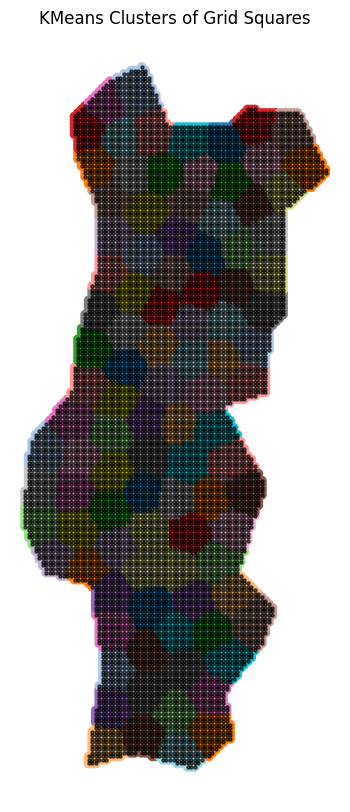

,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,cluster_id
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (458735.144 4286042.239),458735.143906,4.286042e+06,1170.927656,29
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (458735.144 4289042.239),458735.143906,4.289042e+06,886.715418,29
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (458735.144 4292042.239),458735.143906,4.292042e+06,493.847979,29
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (458735.144 4295042.239),458735.143906,4.295042e+06,337.437963,29
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (458735.144 4298042.239),458735.143906,4.298042e+06,670.219187,29


In [52]:
from sklearn.cluster import KMeans

grid_gdf.to_crs(coord_ref_sys)
coords = np.array([(geom.y, geom.x) for geom in grid_gdf.centroid_grid])

# clustering based on geographic closeness
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
grid_gdf["cluster_id"] = kmeans.fit_predict(coords)

fig, ax = plt.subplots(figsize=(10,10))
grid_gdf.plot(column="cluster_id", categorical=True, ax=ax, cmap="tab20")
grid_gdf.geometry.centroid.plot(ax=ax, color="black", markersize=5, alpha=0.6)
ax.set_title("KMeans Clusters of Grid Squares")
ax.set_axis_off()
plt.show()

grid_gdf.head()

In [53]:
from meteostat import Point, Hourly
from datetime import timedelta

start = pd.Timestamp(fire_data["DAY"].min())
end = pd.Timestamp(fire_data["DAY"].max() + timedelta(days=1))

cluster_weather = []

for cluster_id, group in grid_gdf.groupby("cluster_id"):
    # Fetch weather data for each cluster (instead of every grid square)
    lat = group.geometry.centroid.y.mean()
    lon = group.geometry.centroid.x.mean()

    # fetch weather data for the full date range
    df_weather = Hourly(Point(lat, lon), start, end).fetch()

    if not df_weather.empty:
        daily = df_weather.resample("D").mean().reset_index() # daily mean
        daily["DAY"] = daily["time"].dt.date
        daily["cluster_id"] = cluster_id
        # temperature, relative humidity, wind direction, wind speed, air pressure
        cluster_weather.append(daily[["cluster_id", "DAY", "temp", "rhum", "wdir", "wspd", "pres"]])

weather_df = pd.concat(cluster_weather, ignore_index=True)
weather_df.to_csv("cluster_weather.csv", index=False)

weather_df.head()

,cluster_id,DAY,temp,rhum,wdir,wspd,pres
0,55,2016-06-27,21.770833,40.583333,40.555556,9.466667,1020.4625
1,55,2016-06-28,23.758333,38.916667,215.555556,6.891667,1017.775
2,55,2016-06-29,24.879167,38.666667,140.5,5.975,1016.191667
3,55,2016-06-30,24.270833,40.166667,181.73913,13.191667,1014.345833
4,55,2016-07-01,21.983333,33.916667,209.583333,12.908333,1013.795


### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.


In [54]:
# A summary and sample of the graphs list - + persistence
import pickle
with open('output/graphs.pkl', 'wb') as f:
    pickle.dump(graphs, f)
    
print("Number of time steps(graphs)", len(graphs))
print("Example graph for one day:")
graphs[0]

Number of time steps(graphs) 1
Example graph for one day:


,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,index_right,id,FIREDATE,LASTUPDATE,COUNTRY,...,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,centroid_x_fire,centroid_y_fire,DAY,has_fire,geometry_centroid,fire_intensity
0,"POLYGON ((460235.144 4284542.24, 460235.144 42...",POINT (-9.47469 38.72207),458735.143906,4.286042e+06,1170.927656,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-9.47469 38.72207),0
1,"POLYGON ((460235.144 4287542.24, 460235.144 42...",POINT (-9.47487 38.74911),458735.143906,4.289042e+06,886.715418,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-9.47487 38.74911),0
2,"POLYGON ((460235.144 4290542.24, 460235.144 42...",POINT (-9.47505 38.77614),458735.143906,4.292042e+06,493.847979,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-9.47505 38.77614),0
3,"POLYGON ((460235.144 4293542.24, 460235.144 42...",POINT (-9.47523 38.80317),458735.143906,4.295042e+06,337.437963,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-9.47523 38.80317),0
4,"POLYGON ((460235.144 4296542.24, 460235.144 42...",POINT (-9.47541 38.83021),458735.143906,4.298042e+06,670.219187,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-9.47541 38.83021),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10036,"POLYGON ((712235.144 4587542.24, 712235.144 45...",POINT (-6.4781 41.42531),710735.143906,4.589042e+06,94904.168486,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-6.4781 41.42531),0
10037,"POLYGON ((712235.144 4590542.24, 712235.144 45...",POINT (-6.47705 41.45231),710735.143906,4.592042e+06,97407.763803,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-6.47705 41.45231),0
10038,"POLYGON ((712235.144 4593542.24, 712235.144 45...",POINT (-6.47601 41.47931),710735.143906,4.595042e+06,99938.358702,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-6.47601 41.47931),0
10039,"POLYGON ((715235.144 4584542.24, 715235.144 45...",POINT (-6.44329 41.39753),713735.143906,4.586042e+06,90704.117089,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,POINT (-6.44329 41.39753),0


## Attempt to Convert to .npy Format for the Models

In [55]:
date_col = "FIREDATE"   # adjust to your real column name
fire_data[date_col] = pd.to_datetime(fire_data[date_col]).dt.normalize()
full_days = pd.date_range(
    fire_data[date_col].min(),
    fire_data[date_col].max(),
    freq="D"
)